<a href="https://colab.research.google.com/github/BrandenGula/Price_Prediction_Utilizing_ML/blob/main/Final_Capstone_Code_Branden_Gula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [4]:
# using yahooo finance api to extract apple stock stock market data
# Small account, I do not want to day trade. I am using a small account to capture the overall trend and see some nice returns
# Swing trading holding positions for several days to weeks. Therefore, to capture these trends. I will be using
# the daily interval.
data = yf.download('AAPL',
                      start='2022-01-01',
                      end='2024-01-01',
                      interval='1d'
)
data.head(5)

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  177.830002  182.880005  177.710007  182.009995  179.724564   
2022-01-04  182.630005  182.940002  179.119995  179.699997  177.443542   
2022-01-05  179.610001  180.169998  174.639999  174.919998  172.723587   
2022-01-06  172.699997  175.300003  171.639999  172.000000  169.840256   
2022-01-07  172.889999  174.139999  171.029999  172.169998  170.008102   

               Volume  
Date                   
2022-01-03  104487900  
2022-01-04   99310400  
2022-01-05   94537600  
2022-01-06   96904000  
2022-01-07   86709100

In [5]:
# Calculating simple moving averages for Apple's closing price
data['SMA_1'] = data['Close'].rolling(window=1).mean() # short timeframe
data['SMA_5'] = data['Close'].rolling(window=5).mean() # short timeframe
data['SMA_12'] = data['Close'].rolling(window=12).mean() # short timeframe
data['SMA_24'] = data['Close'].rolling(window=24).mean() # short/medium timeframe

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True) # Creating a subplot with 2 axes one for technical indicators and the other is Apple's closing stock price for comparison

ax1.plot(data['SMA_12'], label = 'SMA 12',color='blue') # Plot SMA values for the first axis
ax1.plot(data['SMA_24'], label = 'SMA 24', color='red')
ax1.set_ylabel('SMA and Apple Closing Price', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1)) # Display legend for the first axis

ax2.plot(data['Close'], label = 'Apple Stock Closing Price', color = 'Red')  #Plot Apple Closing price values on the second axis
ax2.set_ylabel('Apple Closing Price')

ax2.legend(loc='upper left',bbox_to_anchor=(1, 1)) # Display legend for the second axis

# Plotting finishing touches
fig.suptitle('Technical Indicator Comparison - MACD/SingalLine and Apple Closing Price')
plt.xlabel('Timeline')
plt.show()

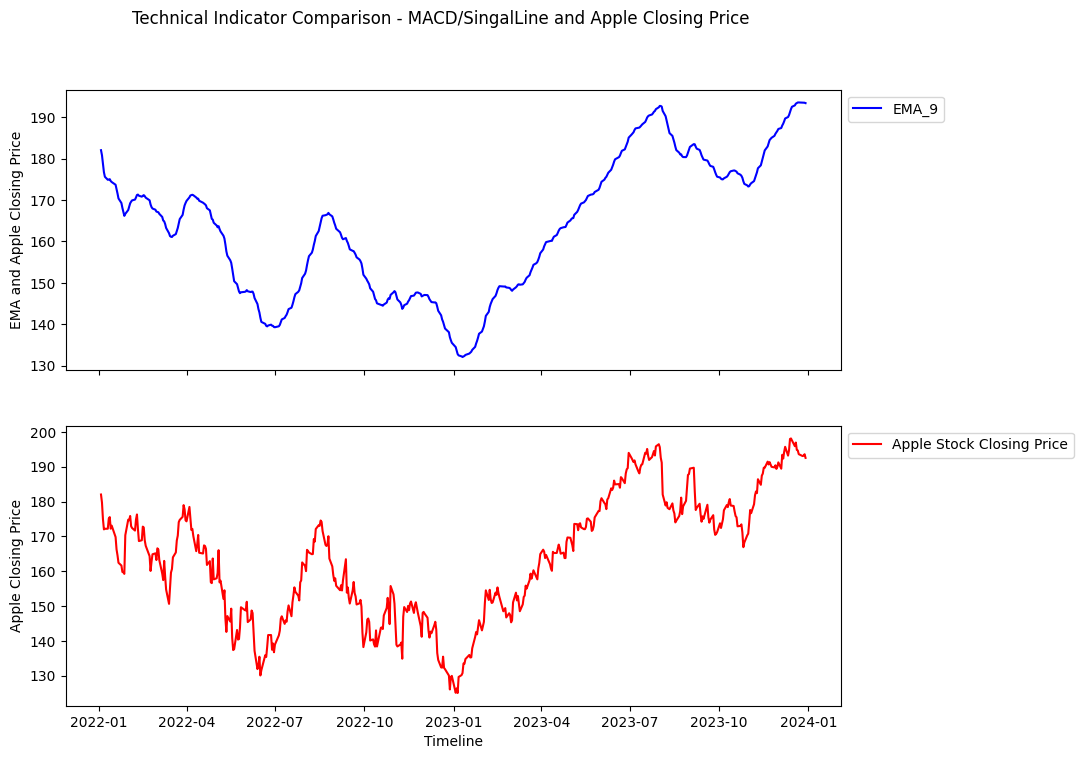

In [6]:
data['EMA_9'] = data['Close'].ewm(9).mean() # Common way to calcluate EMA, common timeframe = 9 for short term trading. Usually combined with SMA for bullish/bearish crossovers

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True) # Creating a subplot with 2 axes one for technical indicators and the other is Apple's closing stock price for comparison

ax1.plot(data['EMA_9'], label = 'EMA_9',color='blue') # Plot EMA values for the first axis
ax1.set_ylabel('EMA and Apple Closing Price', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1)) # Display legend for the first plot as well

ax2.plot(data['Close'], label = 'Apple Stock Closing Price', color = 'Red')  # Plot Apple Closing price values on the second axis
ax2.set_ylabel('Apple Closing Price')

ax2.legend(loc='upper left',bbox_to_anchor=(1, 1)) # Display legend for the second axis

# Plotting finishing touches
fig.suptitle('Technical Indicator Comparison - MACD/SingalLine and Apple Closing Price')
plt.xlabel('Timeline')
plt.show()

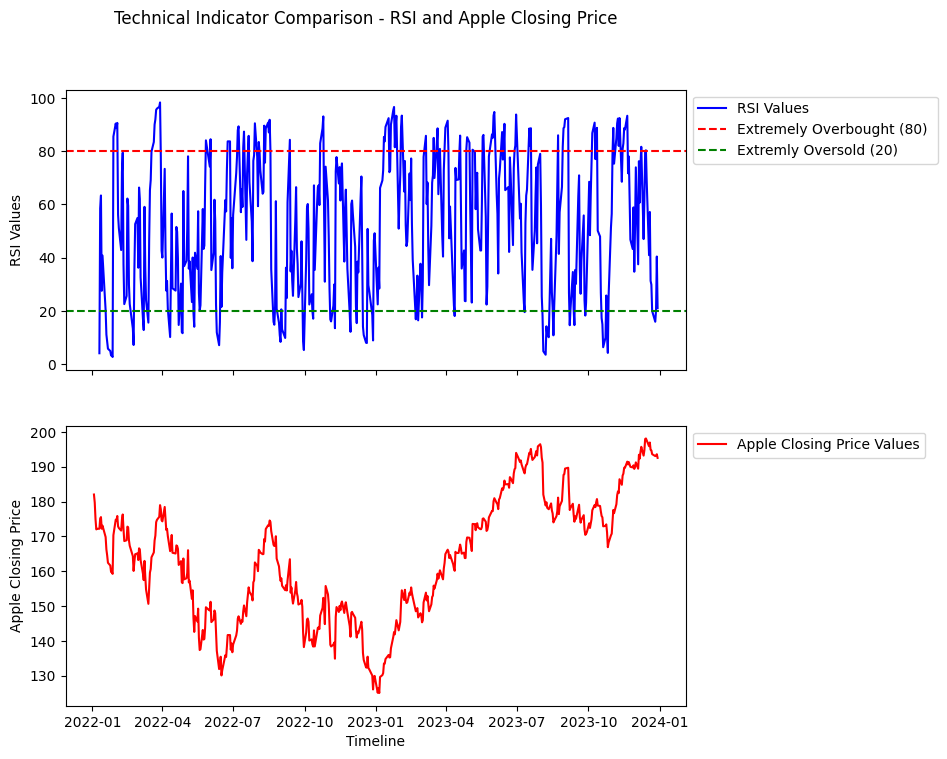

In [7]:
# Source: https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
# Set the value of n to 14. Used to calculate RSI (14)
n = 1

# Calculate the change in price by subtracting Apple stock's previous closing price from the current closing day price
# For example: 2021-01-05 closing price and takes the difference of 131.009995 ( 2021-01-05) - 129.410004 ( 2021-01-04) = 1.599991
data['Change_in_price'] = data['Close'].diff()

# Create two variables that contain the change in price regarding Apple stock that separates positive and negative changes
up_day = data['Change_in_price'].copy()
down_day = data['Change_in_price'].copy()

# sets all the values that are less than 0 to 0.
# Eliminating all negative values and only containing only up days
up_day[up_day < 0] = 0

# sets all values that are greater than 0 to 0
# Eliminating all positive values and only containing only down days
down_day[down_day > 0] = 0

# take the absolute value of the variable down_day, making all values positive
down_day = down_day.abs()

# Calculate the Exponential Weighted Moving Average (EMWA) for up days using the span of n
up_emwa = up_day.ewm(span=n, min_periods=n).mean()

# Calculate the Exponential Weighted Moving Average (EMWA) for up days using the span of n
down_emwa = down_day.ewm(span=n, min_periods=n).mean()

# Calculate relative strength
relative_strength = up_emwa / down_emwa

# Calculate Relative Strength Index (RSI)
rsi = 100.0 - (100.0 / (1.0 + relative_strength))

# Add RSI 1 values to the dataframe
data['RSI 1'] = rsi

n = 3

data['Change_in_price'] = data['Close'].diff()

up_day = data['Change_in_price'].copy()
down_day = data['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

data['RSI 5'] = rsi


n = 5

data['Change_in_price'] = data['Close'].diff()

up_day = data['Change_in_price'].copy()
down_day = data['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

data['RSI 14'] = rsi

n = 21

data['Change_in_price'] = data['Close'].diff()

up_day = data['Change_in_price'].copy()
down_day = data['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

data['RSI 21'] = rsi


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (8,8), sharex=True) # Create a subplot, with two axes stacked on eachother (2 rows, 1 column)

ax1.plot(data['RSI 14'], label='RSI Values', color='blue') # Plot RSI values for the first axis
ax1.set_ylabel('RSI Values')

# Add horizontal dotted lines to indicate extremly overbought and oversold levels
# Source: Assisted me with the inclusion of the horizontal lines https://rbdundas.medium.com/calculate-stochastic-oscillator-in-python-and-pandas-and-chart-with-matplotlib-aafde26b4a1f
ax1.axhline(y=80, color = 'red', linestyle='--',label = 'Extremely Overbought (80) ')
ax1.axhline(y=20, color='green', linestyle='--', label = 'Extremly Oversold (20) ')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1)) # Display legend for the first axis

ax2.plot(data['Close'],label='Apple Closing Price Values', color='red') # Plot Apple Closing price values on the second axis
ax2.set_ylabel('Apple Closing Price')

ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Display legend for the second axis

# Plotting finishing touches
fig.suptitle('Technical Indicator Comparison - RSI and Apple Closing Price')
plt.xlabel('Timeline')
plt.show()

CREATE GBM MODEL tomorrow MAYBE FOR APPLE?
THEN CREATE ANOTHER MODEL FOR NASDAQ?

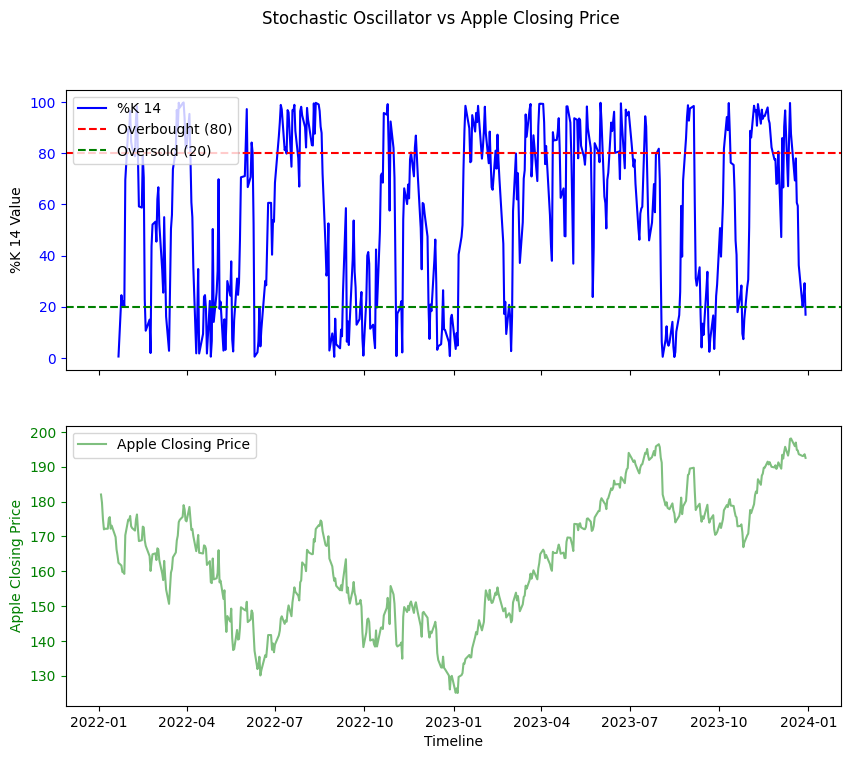

In [8]:
# taking a small group of my dataset this case 14. and performing a calculation on that dataset
# my calc is .min(). As I am going through the data set I am taking the minimum value within that dataset
# .rolling().max() takes the maximum value within the rolling window of 14 tuples, this will continue in every window
# until .rolling reaches the end of the dataset

L14 = data['Low'].rolling(window=1).min()
H14 = data['High'].rolling(window=1).max() # what this does is create a new column called h14. Selecting the data['high' column using the rolling function that takes the windows of 14 tuples and runs the .max() function to extract the max value in every14 tuple window
data['%K 1'] = 100 * ((data['Close']- L14) / (H14-L14))


L14 = data['Low'].rolling(window=5).min()
H14 = data['High'].rolling(window=5).max() # what this does is create a new column called h14. Selecting the data['high' column using the rolling function that takes the windows of 14 tuples and runs the .max() function to extract the max value in every14 tuple window
data['%K 5'] = 100 * ((data['Close']- L14) / (H14-L14))

L14 = data['Low'].rolling(window=14).min()
H14 = data['High'].rolling(window=14).max() # what this does is create a new column called h14. Selecting the data['high' column using the rolling function that takes the windows of 14 tuples and runs the .max() function to extract the max value in every14 tuple window
data['%K 14'] = 100 * ((data['Close']- L14) / (H14-L14))



L14 = data['Low'].rolling(window=21).min()
H14 = data['High'].rolling(window=21).max() # what this does is create a new column called h14. Selecting the data['high' column using the rolling function that takes the windows of 14 tuples and runs the .max() function to extract the max value in every14 tuple window
data['%K 21'] = 100 * ((data['Close']- L14) / (H14-L14))


# fig is the entire figure, ax1 ax2 are the subplots, use .plt.subplots to create the subplots stacked vertically (2,1) 2 rows 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(data['%K 14'], label='%K 14', color='blue') # Plotting %K on the first subplot
ax1.set_ylabel('%K 14 Value', color='black')
ax1.tick_params('y', colors='blue')

# this article helped me with plotting overbought and oversold references for the first subplot (SO)
# https://rbdundas.medium.com/calculate-stochastic-oscillator-in-python-and-pandas-and-chart-with-matplotlib-aafde26b4a1f
ax1.axhline(y=80, color='r', linestyle='--', label='Overbought (80)')
ax1.axhline(y=20, color='g', linestyle='--', label='Oversold (20)')

ax1.legend(loc='upper left') # Display legend for the first axis


ax2.plot(data['Close'], label='Apple Closing Price', alpha=0.5, color='green') # Plotting Apple's closing price on the second subplot
ax2.set_ylabel('Apple Closing Price', color='green')
ax2.tick_params('y', colors='green')

ax2.legend(loc='upper left') # Display legend for the second axis

# Plotting finishing touches
fig.suptitle('Stochastic Oscillator vs Apple Closing Price')
plt.xlabel('Timeline')
plt.show()

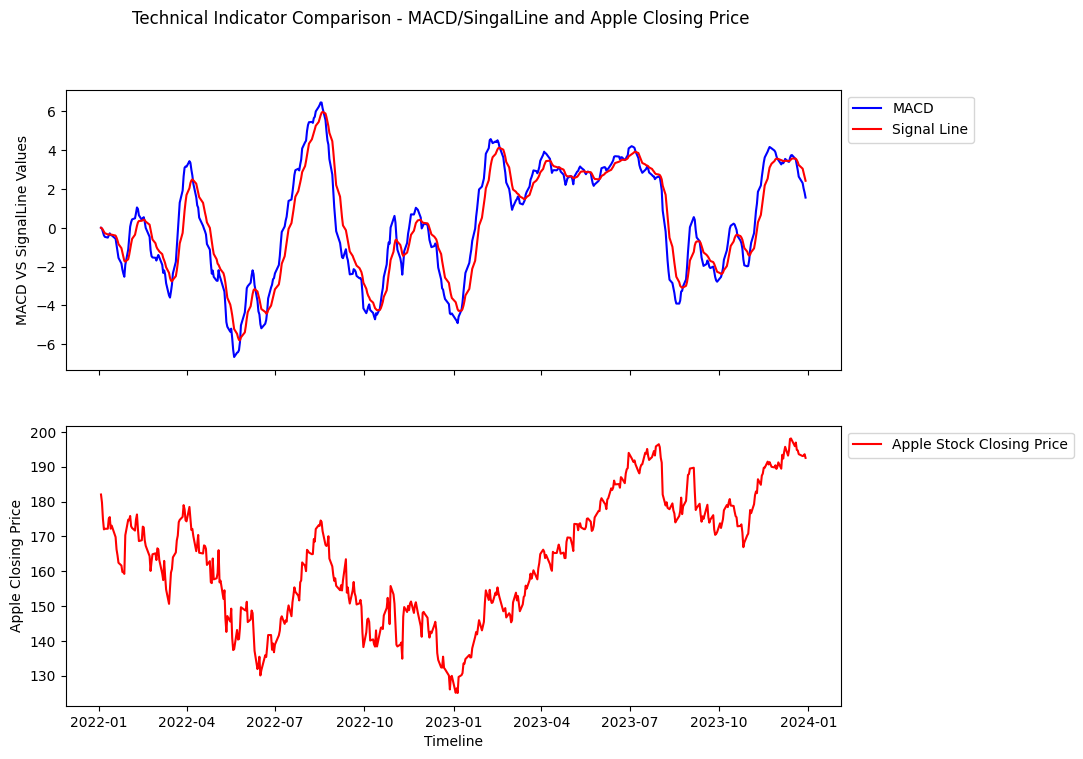

In [9]:
# Moving Average Convergence Divergence MACD
# Source:  https://tcoil.info/compute-macd-indicator-for-stocks-with-python/
# Most common way to calculate MACD 9,12,26
ema_26 = data['Close'].ewm(span=26).mean()
ema_12 = data['Close'].ewm(span=12).mean()

data['MACD'] = ema_12 - ema_26
data['SignalLine'] = data['MACD'].ewm(span = 9).mean()

# Same principle for the figure
fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(data['MACD'], label = 'MACD',color='blue')
ax1.plot(data['SignalLine'], label = 'Signal Line', color='red')
ax1.set_ylabel('MACD VS SignalLine Values', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))


ax2.plot(data['Close'], label = 'Apple Stock Closing Price', color = 'Red')
ax2.set_ylabel('Apple Closing Price')


ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))


fig.suptitle('Technical Indicator Comparison - MACD/SingalLine and Apple Closing Price')
plt.xlabel('Timeline')

plt.show()


# essentially if MACD is > the Signalline column than this indicates a buy signal, vice versa this indicates a sell signal
# if the MACD (Blue line) is above the SignalLine (red line) than that is indicating a bullish signal
# if the MACD is below the signalline than that is indicating a bearish signal

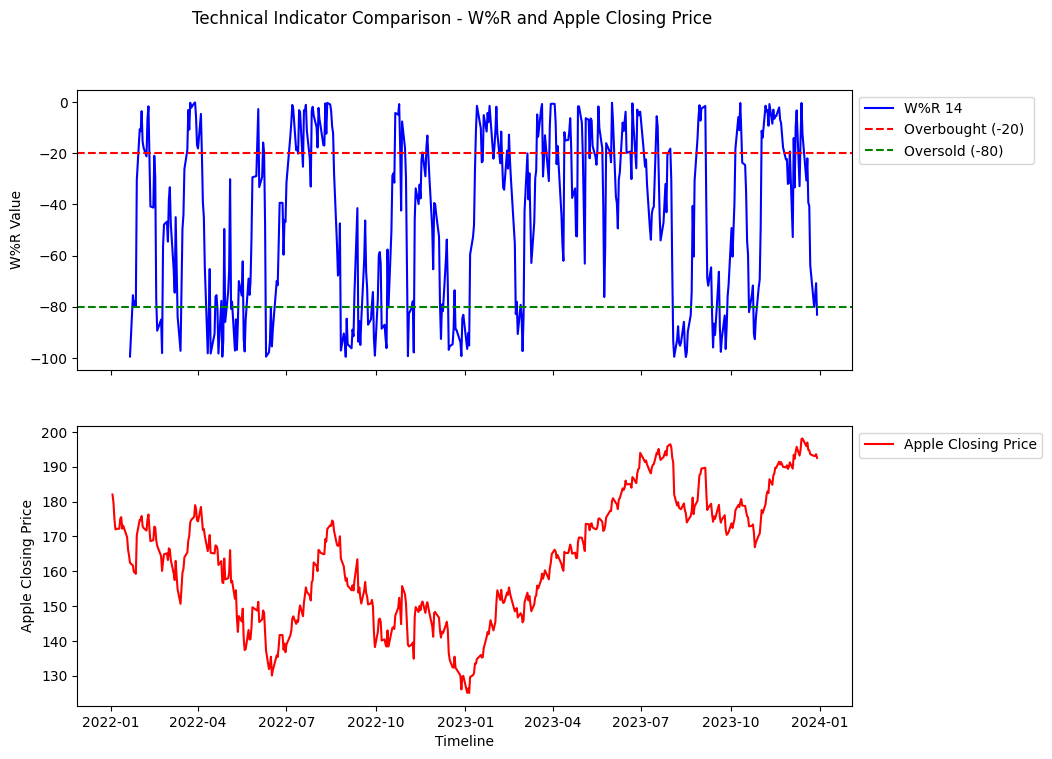

In [10]:
# Williams Percentage (W%R)
# Calculate the highest high over the past 1 day and store it into the 'H14' column
H14 = data['High'].rolling(window=1).max()

# Calculate the lowest low over the past 1 day and store it into the 'L14' column
L14 = data['Low'].rolling(window=1).min()

# Calculate the Williams Percent Range and store the values in the column "W%R"
data['W%R 1'] = (H14 - data['Close']) / (H14 - L14) * -100


H14 = data['High'].rolling(window=3).max()
L14 = data['Low'].rolling(window=3).min()
data['W%R 5'] = (H14 - data['Close']) / (H14 - L14) * -100


H14 = data['High'].rolling(window=14).max()
L14 = data['Low'].rolling(window=14).min()
data['W%R 14'] = (H14 - data['Close']) / (H14 - L14) * -100


H14 = data['High'].rolling(window=21).max()
L14 = data['Low'].rolling(window=21).min()
data['W%R 21'] = (H14 - data['Close']) / (H14 - L14) * -100


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(data['W%R 14'], label = 'W%R 14', color='blue')
ax1.set_ylabel('W%R Value')


# overbought/oversold conditions -80, -20 respectively
ax1.axhline(y=-20,color='r', linestyle='--', label = 'Overbought (-20) ')
ax1.axhline(y=-80,color='g', linestyle='--', label='Oversold (-80) ')

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax2.plot(data['Close'], label = 'Apple Closing Price', color='red')
ax2.set_ylabel('Apple Closing Price')


ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison - W%R and Apple Closing Price')
plt.xlabel('Timeline')
plt.show()

Text(0.5, 0, 'Timeline')

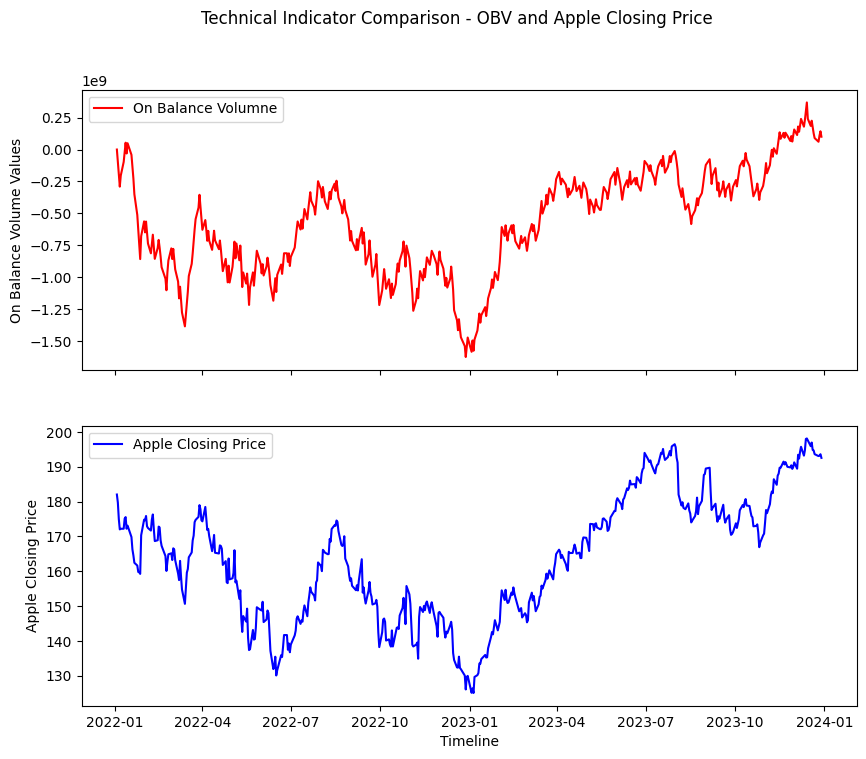

In [11]:
def obv(group):
  # Take the volume and the difference in close price for Apple
    volume = data['Volume']
    change = data['Close'].diff()

    # Initialize the previous OBV value
    prev_obv = 0
    # empty list to store calcluated OBV values
    obv_values = []

    # looping through the pairs of change and volume values
    for i, j in zip(change, volume):
        if i > 0:  # checks if the price change is positive (i > 0), negative (i<0), or 0
            current_obv = prev_obv + j # If the price is positive add previous obv and current volume to curernt_obv
        elif i < 0:
            current_obv = prev_obv - j # If the price is negative subtract the previous obv and the current volume store this information in current_obv
        else:
            current_obv = prev_obv # for 0 price change, keep obv the same

        prev_obv = current_obv # Updating previous obv value
        obv_values.append(current_obv) # append current OBV value to the list
    # Creating a Pandas Series with OBV values, maintain apple's index, and name 'On Balance Volumne'
    return pd.Series(obv_values, index=data.index, name='On Balance Volumne')

# Calling the obv function with the Apple stock's DataFrame and storing the result in the variable obv_values
obv_values = obv(data)

data['OBV'] = obv_values # creating a new column called OBV, that contains the calculated OBV values

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(data['OBV'], label='On Balance Volumne',color='red')
ax1.set_ylabel('On Balance Volume Values')

ax1.legend(loc='upper left')

ax2.plot(data['Close'], label = 'Apple Closing Price', color='blue')
ax2.set_ylabel('Apple Closing Price', color='black')
ax2.tick_params('y', colors='black')


ax2.legend(loc='upper left')


fig.suptitle('Technical Indicator Comparison - OBV and Apple Closing Price')
plt.xlabel('Timeline')

# note volume is equal to 10^9 in the billions. .25 (1/4) of a billion is 250m volume
# -1.5 is -1.5b volumne
# Positive OBV is an indicator that the cumulative volume is tilted towards buyng. Flahses that more volume has
# traded on days when the price closed higher
# Negative cumulative volume is tilited towards selling. Suggests that more volume has traded on days when the price closed lower

Text(0.5, 0, 'Timeline')

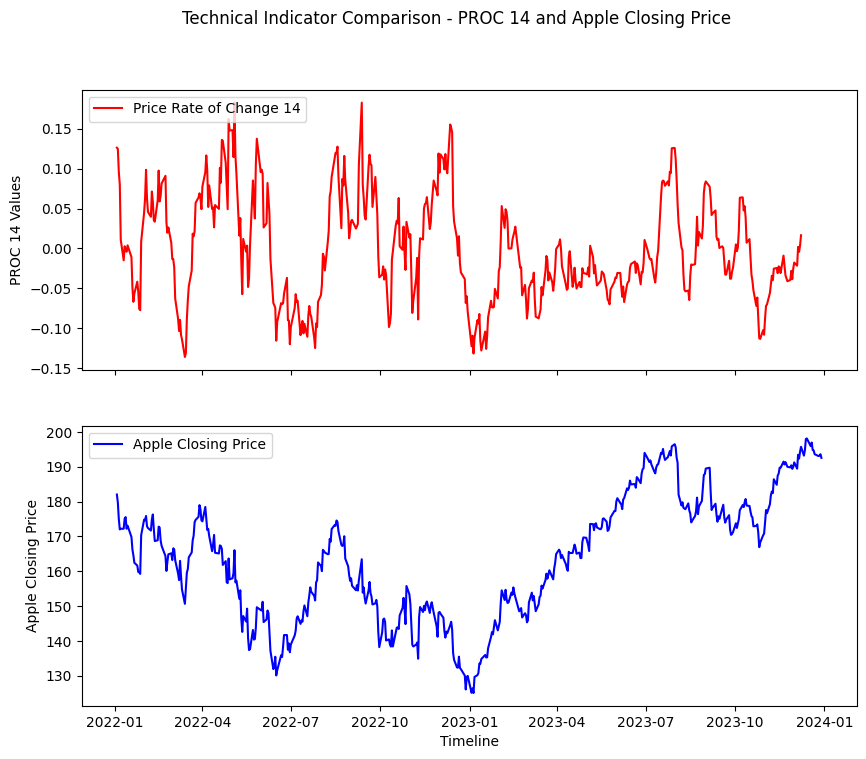

In [12]:
n = 1 # window size of 3
data['PROC 1'] = (data['Close'] - data['Close'].shift(-n)) / data['Close'].shift(-n) # calculating PROC using the same formula given in my paper
# further breakdown essentially you are taking todays closing price subtracting the closing price of 30 days ago then dividing it by the closing price of 1 day ago. The output is the % gain or % loss


n = 5
data['PROC 5'] = (data['Close'] - data['Close'].shift(-n)) / data['Close'].shift(-n)


n = 14
data['PROC 14'] = (data['Close'] - data['Close'].shift(-n)) / data['Close'].shift(-n)


n = 21
data['PROC 21'] = (data['Close'] - data['Close'].shift(-n)) / data['Close'].shift(-n)


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(data['PROC 14'], label = 'Price Rate of Change 14', color = 'red')
ax1.set_ylabel('PROC 14 Values')

ax1.legend(loc='upper left')

ax2.plot(data['Close'], label='Apple Closing Price', color='blue')
ax2.set_ylabel('Apple Closing Price')

ax2.legend(loc='upper left')


fig.suptitle('Technical Indicator Comparison - PROC 14 and Apple Closing Price')
plt.xlabel('Timeline')

Showcase the power of MACD/RSI. Leads to a discovery on why my models performe the way they do

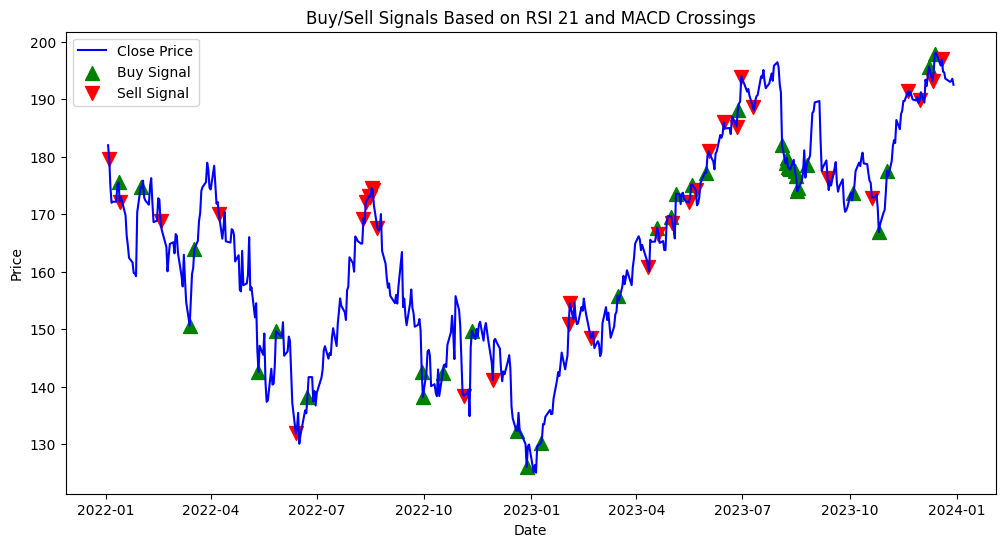

In [13]:
oversold_threshold = {'RSI 21': 30}
overbought_threshold = {'RSI 21': 75}

buy_signals = []
sell_signals = []


for i in range(len(data)):
    signal = ''

    for indicator, threshold in oversold_threshold.items():
        if data[indicator].iloc[i] < threshold:
            signal += 'Oversold '
    for indicator, threshold in overbought_threshold.items():
        if data[indicator].iloc[i] > threshold:
            signal += 'Overbought '

    if data['MACD'].iloc[i] > data['SignalLine'].iloc[i] and data['MACD'].iloc[i-1] <= data['SignalLine'].iloc[i-1]:
        signal += 'Bullish Cross '
    elif data['MACD'].iloc[i] < data['SignalLine'].iloc[i] and data['MACD'].iloc[i-1] >= data['SignalLine'].iloc[i-1]:
        signal += 'Bearish Cross '

    if 'Oversold' in signal or 'Bullish Cross' in signal:
        buy_signals.append((data.index[i], data['Close'].iloc[i]))
    if 'Overbought' in signal or 'Bearish Cross' in signal:
        sell_signals.append((data.index[i], data['Close'].iloc[i]))

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='^', s=100)
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='v', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy/Sell Signals Based on RSI 21 and MACD Crossings')
plt.legend()
plt.show()

As we can see, based on this RSI and MACD combination, the buy signals are far more accurate than the sell signals. As we construct the ML models this trend will remain persistent.

[*********************100%%**********************]  1 of 1 completed


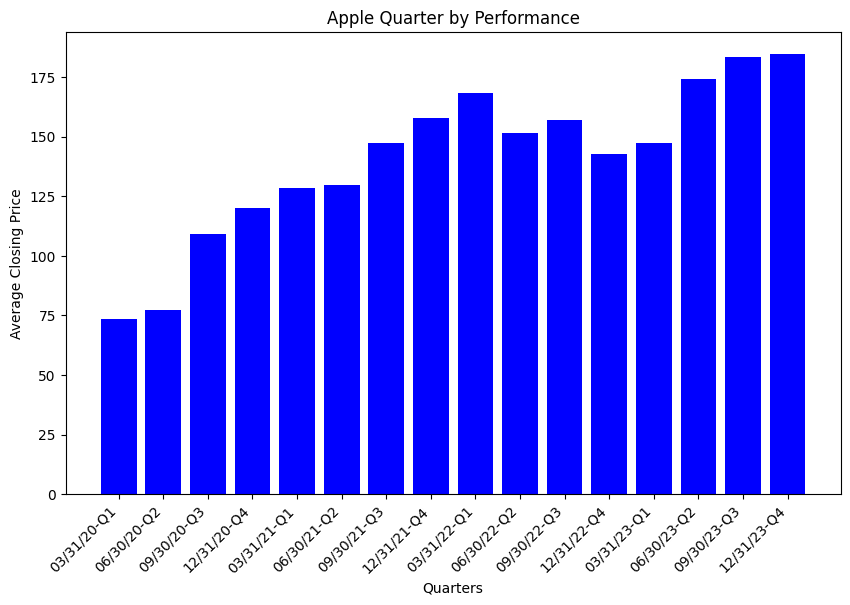

On average Apple generally performs the best in Quarter: 4


In [14]:
# Source that helped me with this. https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
new_aapl = yf.download('AAPL', start = '2020-01-01', end = '2024-01-01')

aapl_quart_performance = new_aapl.resample('Q').mean() # Resample data to quarterly fashion and calculate mean for each quarter

avg_closing_prices = new_aapl.groupby(new_aapl.index.quarter)['Close'].mean() # Calculate the average closing price for each quarter

best_quarter = avg_closing_prices.idxmax() # Identify the quarter with the maximum average closing price
best_quarter = (best_quarter)

aapl_quart_performance['Date'] = aapl_quart_performance.index.to_period('Q').strftime('%D-Q%q') # Updating the date index column to represent the start of each quarter with the formatted string (year then quarter)

plt.figure(figsize=(10,6)) # Plot Apple's quarter by performance
plt.bar(aapl_quart_performance['Date'], aapl_quart_performance['Close'],color='blue')
plt.title('Apple Quarter by Performance')
plt.xlabel('Quarters')
plt.ylabel('Average Closing Price')
plt.xticks(rotation = 45, ha='right')
plt.show()

print('On average Apple generally performs the best in Quarter:', best_quarter)

In [15]:
# includes all technical indicator correlations with Apple stock closing price
RSI_corr = data['RSI 14'].corr(data['Close'])
print('RSI correlation with Apple Closing Price:', RSI_corr, '\n')

so_corr = data['%K 14'].corr(data['Close'])
print('Stochastic Oscillator correlation with Apple Closing Price:', so_corr, '\n')

williams_corr = data['W%R 14'].corr(data['Close'])
print('W%R correlation with Apple Closing Price:', williams_corr, '\n')

macd_corr = data['MACD'].corr(data['Close'])
print('MACD correlation with Apple Closing Price:', macd_corr, '\n')

signal_line_corr = data['SignalLine'].corr(data['Close'])
print('SignalLine correlation with Apple Closing Price:', signal_line_corr, '\n')

macd_signalLine_corr = data['MACD'].corr(data['SignalLine'])
print('MACD correlation with SignalLine ', macd_signalLine_corr, '\n')

obv_corr = data['OBV'].corr(data['Close'])
print('OBV correlation with Apple Closing Price:', obv_corr, '\n')

obv_descriptive = data['OBV'].describe() # All descriptive stats for technical indicators regarding Apple stock
print('Descriptive Statistics for OBV', obv_descriptive)
rsi_descriptive = data['RSI 14'].describe()
print('Descriptive Statistics for RSI:', rsi_descriptive)
WR_descriptive = data['W%R 14'].describe()
print('Descriptive Statistics for W%R', WR_descriptive)
macd_descriptive = data['MACD'].describe()
print('Descriptive Statistics for MACD: ', macd_descriptive)
sigLine_stats = data['SignalLine'].describe()
print('Descriptive Statistics for SignalLine', sigLine_stats)

RSI correlation with Apple Closing Price: 0.19563401358099305 

Stochastic Oscillator correlation with Apple Closing Price: 0.32231502434752163 

W%R correlation with Apple Closing Price: 0.3223150243475215 

MACD correlation with Apple Closing Price: 0.5428992274091271 

SignalLine correlation with Apple Closing Price: 0.5539467605621871 

MACD correlation with SignalLine  0.9477519667491862 

OBV correlation with Apple Closing Price: 0.8759041103724997 

Descriptive Statistics for OBV count    5.010000e+02
mean    -5.691107e+08
std      4.045439e+08
min     -1.626434e+09
25%     -8.954805e+08
50%     -5.474814e+08
75%     -2.722854e+08
max      3.692399e+08
Name: OBV, dtype: float64
Descriptive Statistics for RSI: count    496.000000
mean      52.373171
std       26.275283
min        2.626291
25%       29.630834
50%       54.904766
75%       75.336318
max       98.322031
Name: RSI 14, dtype: float64
Descriptive Statistics for W%R count    488.000000
mean     -43.999390
std       32.5

In [16]:


data.head(5)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  177.830002  182.880005  177.710007  182.009995  179.724564   
2022-01-04  182.630005  182.940002  179.119995  179.699997  177.443542   
2022-01-05  179.610001  180.169998  174.639999  174.919998  172.723587   
2022-01-06  172.699997  175.300003  171.639999  172.000000  169.840256   
2022-01-07  172.889999  174.139999  171.029999  172.169998  170.008102   

               Volume       SMA_1       SMA_5  SMA_12  SMA_24  ...  \
Date                                                           ...   
2022-01-03  104487900  182.009995         NaN     NaN     NaN  ...   
2022-01-04   99310400  179.699997         NaN     NaN     NaN  ...   
2022-01-05   94537600  174.919998         NaN     NaN     NaN  ...   
2022-01-06   96904000  172.000000         NaN     NaN     NaN  ...   
2022-01-07   86709100  172.169998  176.159998     NaN     NaN  ...   

            SignalLine      W%R 1      W%R 5  W%R 14  W%R 21        OBV  \
Date                                                                      
2022-01-03    0.000000 -16.828060        NaN     NaN     NaN          0   
2022-01-04   -0.028793 -84.816735        NaN     NaN     NaN  -99310400   
2022-01-05   -0.104806 -94.936730 -96.626522     NaN     NaN -193848000   
2022-01-06   -0.200847 -90.163928 -96.814155     NaN     NaN -290752000   
2022-01-07   -0.280307 -63.344078 -87.527358     NaN     NaN -204042900   

              PROC 1    PROC 5   PROC 14   PROC 21  
Date                                                
2022-01-03  0.012855  0.057030  0.126160  0.035089  
2022-01-04  0.027327  0.026388  0.124671  0.039329  
2022-01-05  0.016977 -0.003475  0.095372  0.014676  
2022-01-06 -0.000987 -0.001103  0.080266  0.001981  
2022-01-07 -0.000116 -0.005200  0.010803 -0.015215  

[5 rows x 31 columns]

My original model that was prone to data leakage, I had no clear direction. No real world application (technical indicators did not complement eachother), overall a total mess.
Title in Paper: Second Optimized RFR Model Top 3 Indicators

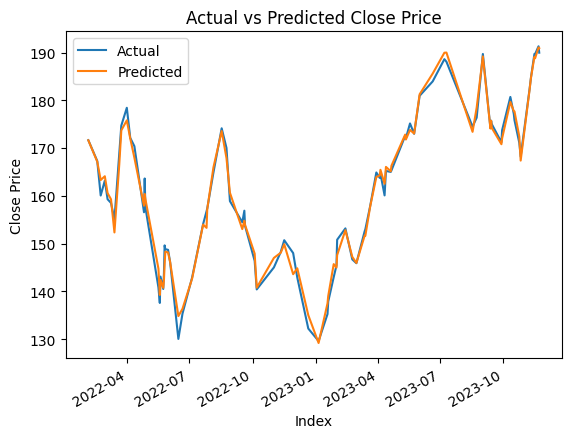

Training Mean Aboslute Error: 0.847689207587083
Test Mean Aboslute Error: 1.2367988740737135
Mean Squared Error 2.7315615482155953
R2 Score 0.9887629387224688


In [17]:
data['Next_Close'] = data['Close'].shift(-1) # Creating a target variable called Next_Close. The idea here is to use todays data to predict tomorrows closing price

data = data.dropna() # Random Forest is not happy with NaN values, therefore I drop all NaN values in Apple stock's data frame.

predictors = ['SMA_1','SMA_5','PROC 1'] # Using my technical indicators as my predictors. To assist my training data to predict my testing data.

target_variable = 'Next_Close'

x = data[predictors] # Splitting my data into predictors x and target variable y
y = data[target_variable]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # Splitting the data into 80% training and 20% testing

model = RandomForestRegressor(n_estimators=350, min_samples_split=3, max_depth=5) # Initialize RandomForestRegressor


model.fit(x_train, y_train) # Train the model

preds = model.predict(x_test) # Make predictions based on the trained model

combined = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
combined.plot() # Plot the actual and predicted values
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

# Performance Metrics Random Forest Regressor Model:
# Source: https://www.youtube.com/watch?v=YUsx5ZNlYWc
mae_train = mean_absolute_error(y_train, model.predict(x_train))
mae_test = mean_absolute_error(y_test, preds)
mse = mean_squared_error(preds, y_test)
r2 = r2_score(preds, y_test)

print("Training Mean Aboslute Error:", mae_train)
print("Test Mean Aboslute Error:", mae_test)
print('Mean Squared Error', mse)
print('R2 Score', r2)

Updated model that dimishes data leakage by taking the length of the data and use 80% of the data for training. Utilize a combination of technical indicators that can be applied to the real world. Performed GridSearch to find the optimal hyperparameters for my models

<ipython-input-18-8efba864cdf0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = train_data['Close'].shift(-1) # Creating the target variable
<ipython-input-18-8efba864cdf0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Target'] = test_data['Close'].shift(-1)


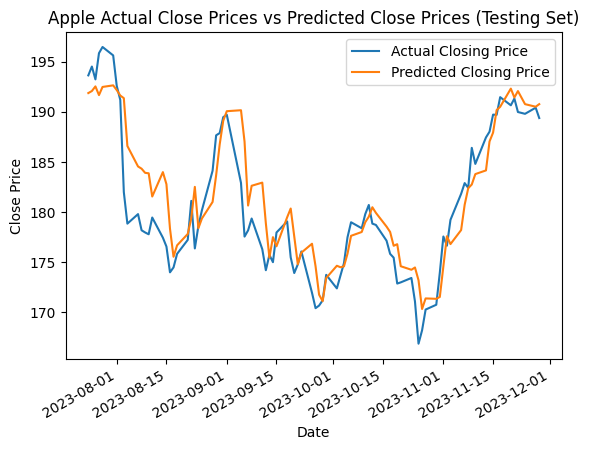

Training Mean Absolute Error: 1.6371202685724426
Test Mean Absolute Error: 2.4791860725473946
Mean Squared Error: 11.111441251119142
R2 Score: 0.7892076030401604


In [18]:
total_samples = len(data)
train_samples = int(total_samples * 0.8)  # 80% of Apple stock data will be used for training

split_index = train_samples  # Variable used to split Apple stock data

# Split the Apple stock data into training and testing splits
train_data = data[:split_index]  # All Apple stock data up to split_index for training
test_data = data[split_index:]  # All Apple stock data from split_index and so on for testing

train_data['Target'] = train_data['Close'].shift(-1) # Creating the target variable
test_data['Target'] = test_data['Close'].shift(-1)

train_data = train_data.dropna() # Random Forest Regressor is not happy with NaN values
test_data = test_data.dropna()

predictors = ['RSI 14', 'PROC 5', 'MACD', 'OBV', 'EMA_9','%K 14','SMA_12','SignalLine','W%R 14','High', 'Low', 'Adj Close', 'Open', 'Close']

x_train = train_data[predictors] # Splitting the data into predictors (x) and target variable (y)
y_train = train_data['Target']  # Target variable is the close price for the next day
x_test = test_data[predictors]
y_test = test_data['Target']

model = RandomForestRegressor(n_estimators=500, min_samples_split=5, max_depth=5) # Initialize Random Forest Regressor model with optimized hyperparameters

model.fit(x_train, y_train) # Train the model

preds = model.predict(x_test) # Use the trained model to make predictions

combined_test_results = pd.DataFrame({'Actual Closing Price': y_test, 'Predicted Closing Price': preds}, index=y_test.index)

combined_test_results.plot() # Plot the actual and predicted values for the testing set
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Apple Actual Close Prices vs Predicted Close Prices (Testing Set)')
plt.legend()
plt.show()

mae_train = mean_absolute_error(y_train, model.predict(x_train)) # Evaluate the model's performance based on common performance metrics
mae_test = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Training Mean Absolute Error:", mae_train)
print("Test Mean Absolute Error:", mae_test)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)


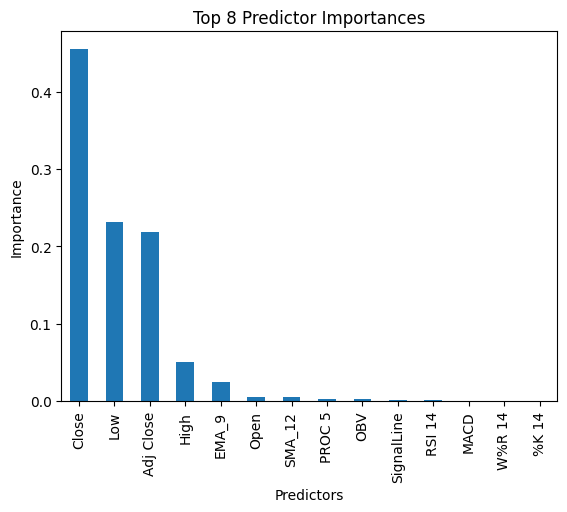

In [19]:
preds_list = list(x_train.columns) # Creating a list of predictor names from the training set
preds_importance = pd.Series(model.feature_importances_, index=preds_list).sort_values(ascending=False) # Creating a panda series of predictor importances, order by DESC

importances = preds_importance.nlargest(15).plot(kind='bar') # Plotting all the predictors
plt.xlabel('Predictors')
plt.ylabel('Importance')
plt.title('Top 8 Predictor Importances')
plt.show()

I am not satisfied with the results because yahoo finance columns dominate the technical indicators. Thus making it difficult to apply it to the real world. Approach 2: Will use binary classifcation that solely uses technical indicators as predictors

In [20]:
total_samples = len(data)
train_samples = int(total_samples * 0.8)  # 80% of the Apple stock data will be used for training

split_index = train_samples  # Variable used to split Apple stock data

# Split the Apple stock data into training and testing splits
train_data = data[:split_index]  # All Apple stock data up to split_index for training
test_data = data[split_index:]   # All Apple stock data from split_index and so on for testing

train_data['Next_Close'] = train_data['Close'].shift(-1) # Creating the target variable
train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)

test_data['Next_Close'] = test_data['Close'].shift(-1)
test_data['Target'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

train_data = train_data.dropna() # XGBoost Classifier is not happy with NaN values
test_data = test_data.dropna()

predictors = ['RSI 14', 'PROC 5', 'MACD', 'OBV', 'EMA_9', '%K 14', 'SMA_5', 'SignalLine', 'W%R 14']


x_train = train_data[predictors] # Splitting the data into predictors (x) and target variable (y)
y_train = train_data['Target'] # Target variable is the close price for the next day
x_test = test_data[predictors]
y_test = test_data['Target']

model = xgb.XGBClassifier(n_estimators=300, max_depth=1, learning_rate=0.1, min_child_weight=1) # Initialize XGBoost Classifier

model.fit(x_train, y_train) # Train the model

preds = model.predict(x_test) # Used the trained model to make predictions

# Calculating Classification Performance Metrics
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("Accuracy:", accuracy) # Printing Classifcation Performance Metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

report = classification_report(y_test, preds) # Creating a classification report
print("Classification Report: ")
print(report)




Accuracy: 0.6222222222222222
Precision: 0.6904761904761905
Recall: 0.58
F1-score: 0.6304347826086957
Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.68      0.61        40
           1       0.69      0.58      0.63        50

    accuracy                           0.62        90
   macro avg       0.63      0.63      0.62        90
weighted avg       0.63      0.62      0.62        90



<ipython-input-20-ab612bff92b9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Next_Close'] = train_data['Close'].shift(-1) # Creating the target variable
<ipython-input-20-ab612bff92b9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)
<ipython-input-20-ab612bff92b9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Tieing back that MACD and RSI buy/sell signals. From the data analysis we've done, majority of the models will perform more accurately for the up days compared to the down days

In [21]:
total_samples = len(data)
train_samples = int(total_samples * 0.8)  # 80% of the Apple stock data will be used for training

split_index = train_samples  # Variable used to split Apple stock data

# Splitting Apple stock data into training and testing splits
train_data = data[:split_index]  # All Apple stock data up to split_index for training
test_data = data[split_index:]   # All Apple stock data from split_index and so on for testing

train_data['Next_Close'] = train_data['Close'].shift(-1) # Creating target variables
train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)

test_data['Next_Close'] = test_data['Close'].shift(-1)
test_data['Target'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

train_data = train_data.dropna() # RFC is not happy with NaN values
test_data = test_data.dropna()

features = ['RSI 5', 'PROC 5', 'MACD', 'OBV', 'EMA_9','%K 5','SMA_5','SignalLine','W%R 5']


x_train = train_data[features]  # Splitting the data into features (x) and target variable (y)
y_train = train_data['Target']  # Target variable is the close price for the next day
x_test = test_data[features]
y_test = test_data['Target']


model = RandomForestClassifier(n_estimators=200, max_depth=1, min_samples_leaf=3, min_samples_split=4) # Initialize optimized Random Forest Classifier

model.fit(x_train, y_train) # Training the model

preds = model.predict(x_test) # Use the trained model to make predictions


accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("Accuracy:", accuracy) # Printing Classifcation Performance Metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

report = classification_report(y_test, preds) # Creating a classification report
print("Classification Report: ")
print(report)

<ipython-input-21-bfccc60a825d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Next_Close'] = train_data['Close'].shift(-1) # Creating target variables
<ipython-input-21-bfccc60a825d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)
<ipython-input-21-bfccc60a825d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Accuracy: 0.6777777777777778
Precision: 0.723404255319149
Recall: 0.68
F1-score: 0.7010309278350516
Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.68      0.65        40
           1       0.72      0.68      0.70        50

    accuracy                           0.68        90
   macro avg       0.68      0.68      0.68        90
weighted avg       0.68      0.68      0.68        90



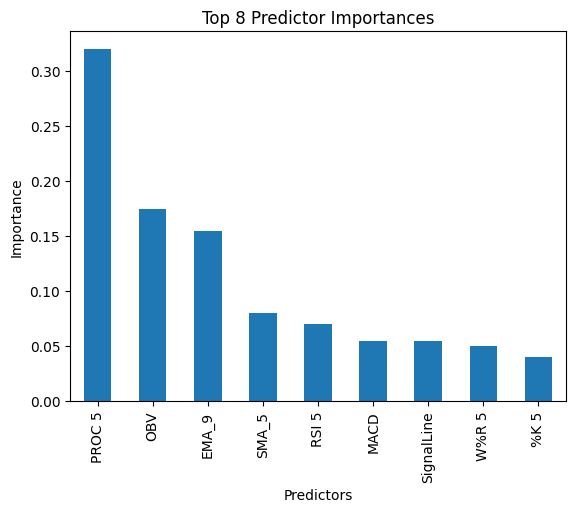

In [22]:
preds_list = list(x_train.columns) # Creating a list of predictor names from the training set
preds_importance = pd.Series(model.feature_importances_, index=preds_list).sort_values(ascending=False) # Creating a panda series of predictor importances, order by DESC

importances = preds_importance.nlargest(15).plot(kind='bar') # Plotting all the predictors
plt.xlabel('Predictors')
plt.ylabel('Importance')
plt.title('Top 8 Predictor Importances')
plt.show()

Gridsearch was ulitlzied to identify the best hyperparameters for my models

**Extracting PLTR's Data using Yahoo Finance API**

In [23]:
pltr = yf.download('PLTR',
                      start='2022-01-01',
                      end='2024-02-01',
                      interval = '1D'
)

[*********************100%%**********************]  1 of 1 completed


Simple Moving average

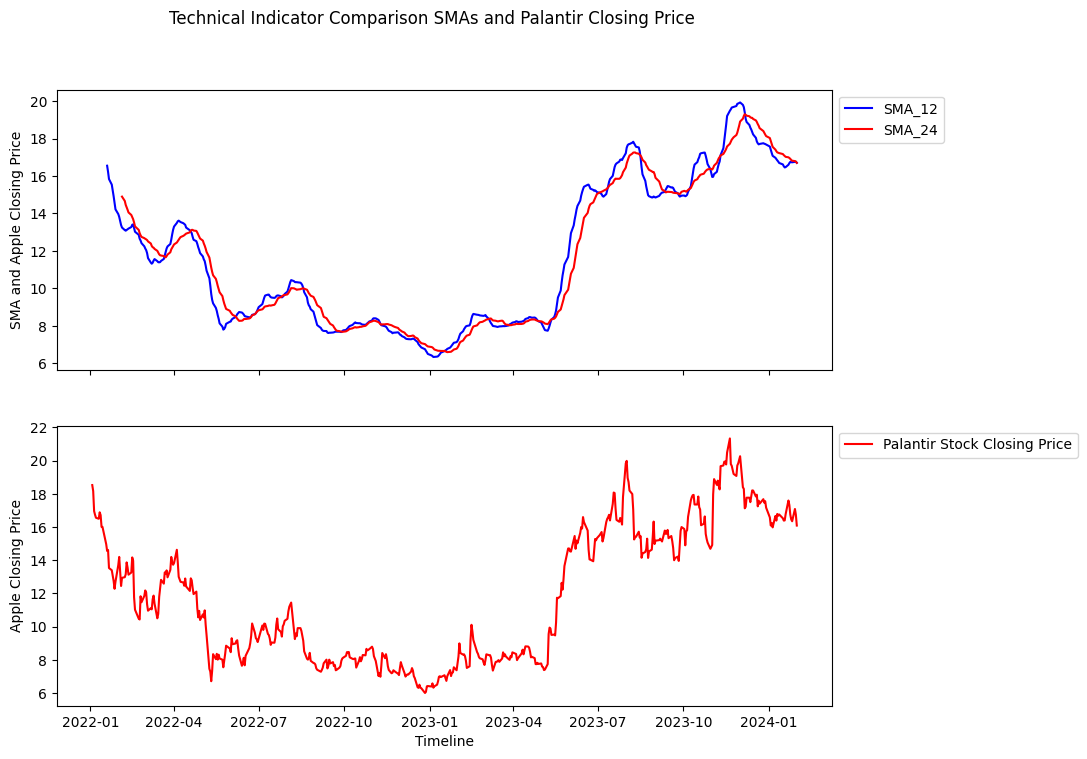

In [24]:
pltr['SMA_1'] = pltr['Close'].rolling(window=1).mean()
pltr['SMA_5'] = pltr['Close'].rolling(window=5).mean()
pltr['SMA_12'] = pltr['Close'].rolling(window=12).mean()
pltr['SMA_24'] = pltr['Close'].rolling(window=24).mean()

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(pltr['SMA_12'], label = 'SMA_12',color='blue')
ax1.plot(pltr['SMA_24'], label = 'SMA_24', color='red')
ax1.set_ylabel('SMA and Apple Closing Price', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))

ax2.plot(pltr['Close'], label = 'Palantir Stock Closing Price', color = 'Red')
ax2.set_ylabel('Apple Closing Price')

ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison SMAs and Palantir Closing Price')
plt.xlabel('Timeline')
plt.show()

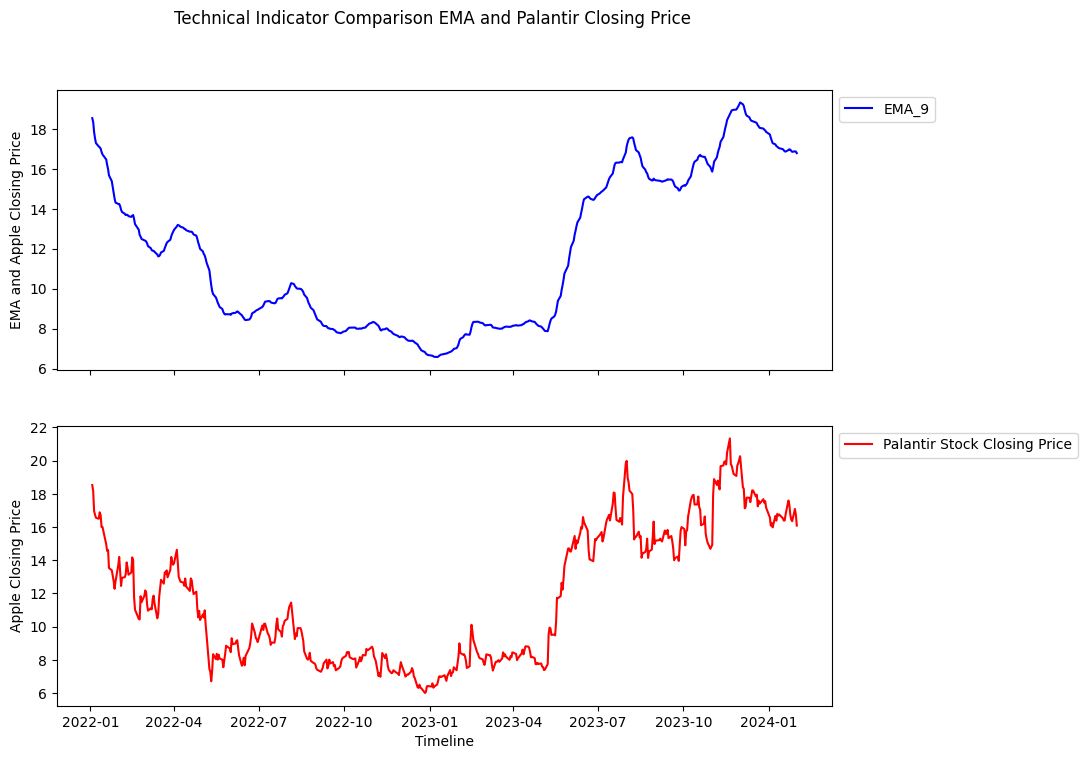

In [25]:
pltr['EMA_9'] = pltr['Close'].ewm(9).mean()

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(pltr['EMA_9'], label = 'EMA_9',color='blue')
ax1.set_ylabel('EMA and Apple Closing Price', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))

ax2.plot(pltr['Close'], label = 'Palantir Stock Closing Price', color = 'Red')
ax2.set_ylabel('Apple Closing Price')

ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison EMA and Palantir Closing Price')
plt.xlabel('Timeline')
plt.show()

Pltr Relative Strength Index

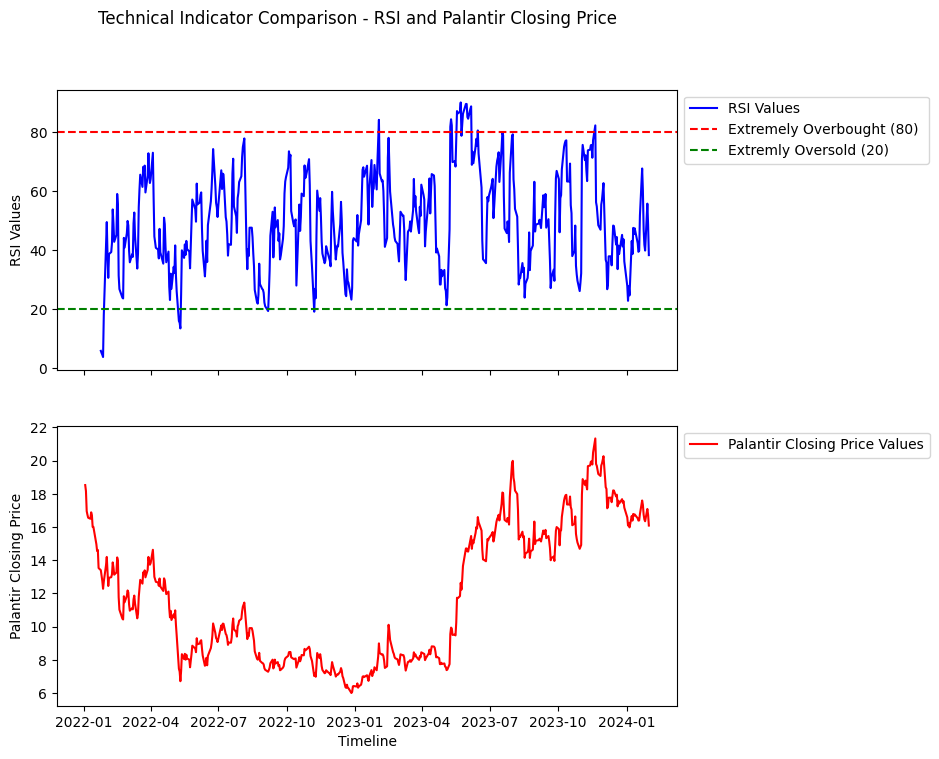

In [26]:
n = 1

pltr['Change_in_price'] = pltr['Close'].diff()

up_day = pltr['Change_in_price'].copy()
down_day = pltr['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

pltr['RSI 1'] = rsi

n = 5

pltr['Change_in_price'] = pltr['Close'].diff()

up_day = pltr['Change_in_price'].copy()
down_day = pltr['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

pltr['RSI 5'] = rsi


n = 14

pltr['Change_in_price'] = pltr['Close'].diff()

up_day = pltr['Change_in_price'].copy()
down_day = pltr['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

pltr['RSI 14'] = rsi



n = 21

pltr['Change_in_price'] = pltr['Close'].diff()

up_day = pltr['Change_in_price'].copy()
down_day = pltr['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

pltr['RSI 21'] = rsi


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (8,8), sharex=True)

ax1.plot(pltr['RSI 14'], label='RSI Values', color='blue')
ax1.set_ylabel('RSI Values')

ax1.axhline(y=80, color = 'red', linestyle='--',label = 'Extremely Overbought (80) ')
ax1.axhline(y=20, color='green', linestyle='--', label = 'Extremly Oversold (20) ')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))

ax2.plot(pltr['Close'],label='Palantir Closing Price Values', color='red')
ax2.set_ylabel('Palantir Closing Price')

ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison - RSI and Palantir Closing Price')

plt.xlabel('Timeline')

plt.show()

Pltr Stochastic Oscillator

Text(0.5, 0, 'Timeline')

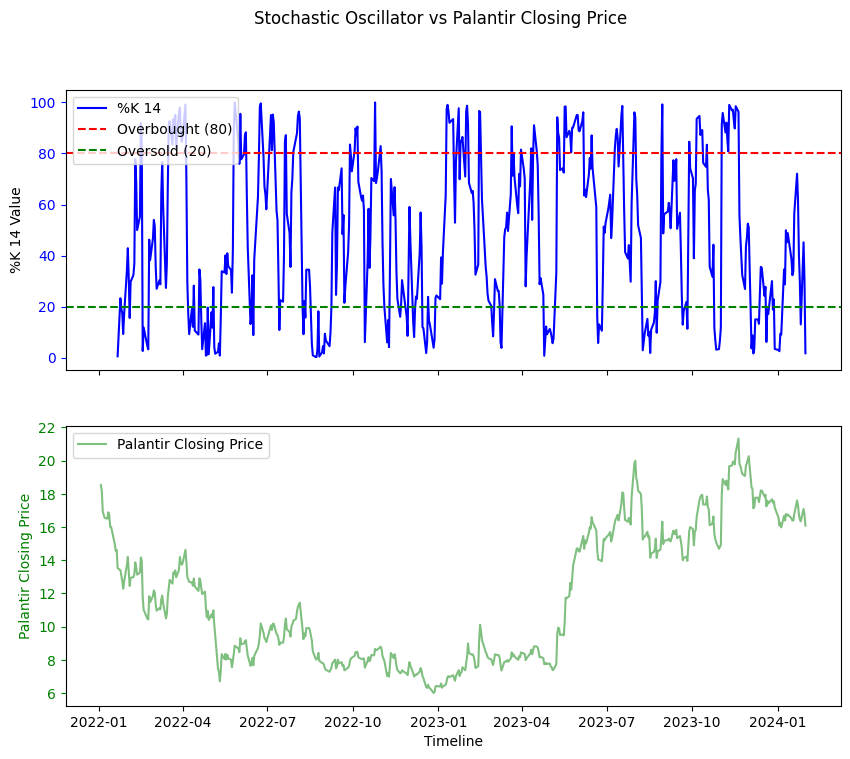

In [27]:
L14 = pltr['Low'].rolling(window=1).min()
H14 = pltr['High'].rolling(window=1).max()
pltr['%K 1'] = 100 * ((pltr['Close']- L14) / (H14-L14))


L14 = pltr['Low'].rolling(window=5).min()
H14 = pltr['High'].rolling(window=5).max()
pltr['%K 5'] = 100 * ((pltr['Close']- L14) / (H14-L14))

L14 = pltr['Low'].rolling(window=14).min()
H14 = pltr['High'].rolling(window=14).max()
pltr['%K 14'] = 100 * ((pltr['Close']- L14) / (H14-L14))



L14 = pltr['Low'].rolling(window=21).min()
H14 = pltr['High'].rolling(window=21).max()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(pltr['%K 14'], label='%K 14', color='blue')
ax1.set_ylabel('%K 14 Value', color='black')
ax1.tick_params('y', colors='blue')

ax1.axhline(y=80, color='r', linestyle='--', label='Overbought (80)')
ax1.axhline(y=20, color='g', linestyle='--', label='Oversold (20)')

ax1.legend(loc='upper left')

ax2.plot(pltr['Close'], label='Palantir Closing Price', alpha=0.5, color='green')
ax2.set_ylabel('Palantir Closing Price', color='green')
ax2.tick_params('y', colors='green')

ax2.legend(loc='upper left')

fig.suptitle('Stochastic Oscillator vs Palantir Closing Price')
plt.xlabel('Timeline')

Pltr MACD/SignalLine

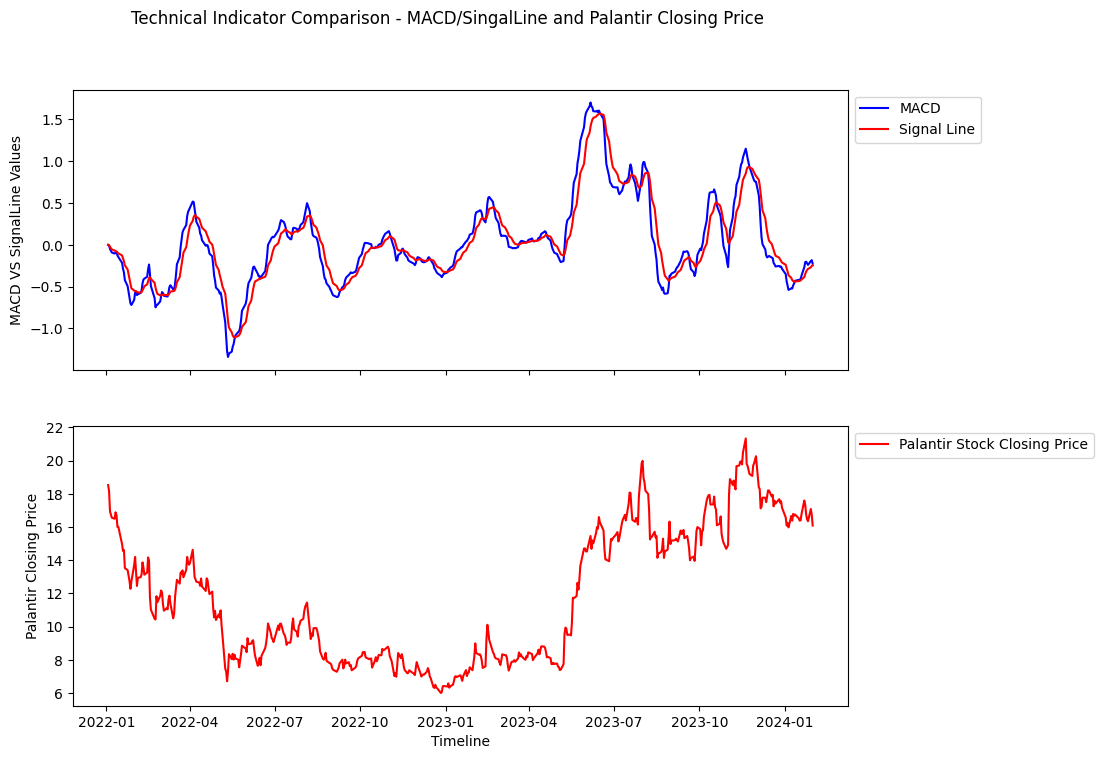

In [28]:
ema_26 = pltr['Close'].ewm(span=26).mean()
ema_12 = pltr['Close'].ewm(span=12).mean()

pltr['MACD'] = ema_12 - ema_26
pltr['SignalLine'] = pltr['MACD'].ewm(span = 9).mean()


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)


ax1.plot(pltr['MACD'], label = 'MACD',color='blue')
ax1.plot(pltr['SignalLine'], label = 'Signal Line', color='red')
ax1.set_ylabel('MACD VS SignalLine Values', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))


ax2.plot(pltr['Close'], label = 'Palantir Stock Closing Price', color = 'Red')
ax2.set_ylabel('Palantir Closing Price')


ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))


fig.suptitle('Technical Indicator Comparison - MACD/SingalLine and Palantir Closing Price')
plt.xlabel('Timeline')

plt.show()

Pltr Williams Percent Range

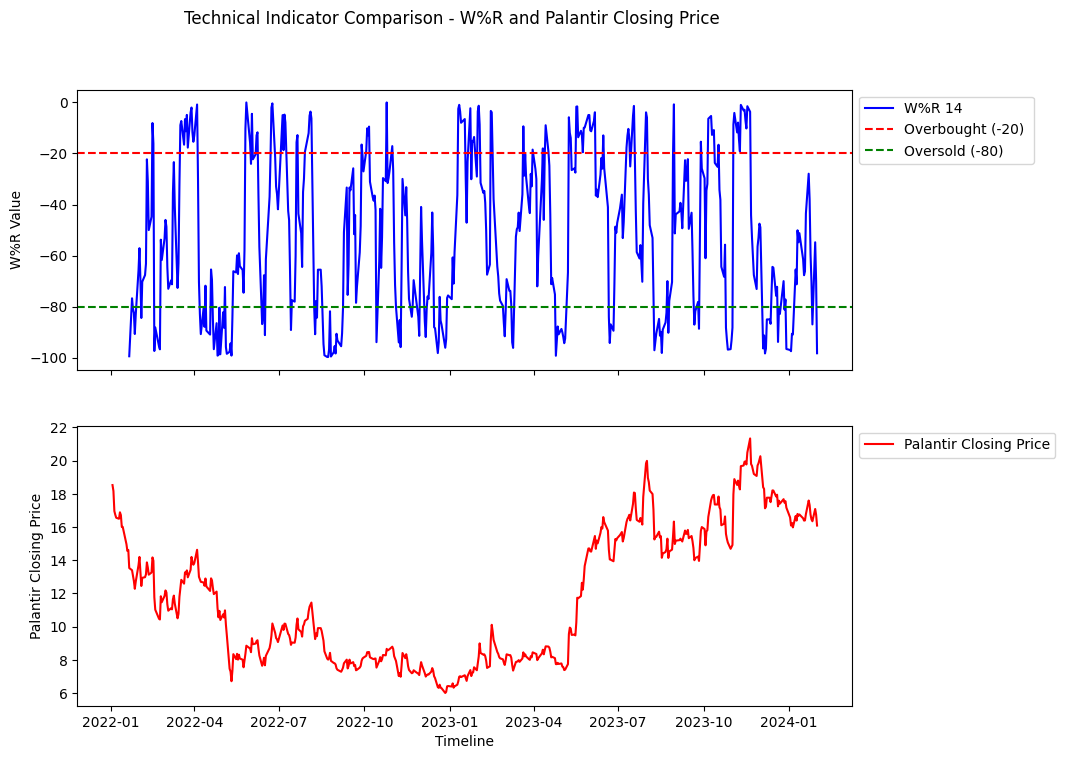

In [29]:
H14 = pltr['High'].rolling(window=1).max()

L14 = pltr['Low'].rolling(window=1).min()

pltr['W%R 1'] = (H14 - pltr['Close']) / (H14 - L14) * -100


H14 = pltr['High'].rolling(window=5).max()
L14 = pltr['Low'].rolling(window=5).min()
pltr['W%R 5'] = (H14 - pltr['Close']) / (H14 - L14) * -100


H14 = pltr['High'].rolling(window=14).max()
L14 = pltr['Low'].rolling(window=14).min()
pltr['W%R 14'] = (H14 - pltr['Close']) / (H14 - L14) * -100

H14 = pltr['High'].rolling(window=21).max()
L14 = pltr['Low'].rolling(window=21).min()
pltr['W%R 21'] = (H14 - pltr['Close']) / (H14 - L14) * -100


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(pltr['W%R 14'], label = 'W%R 14', color='blue') # Change the line plotting itself
ax1.set_ylabel('W%R Value')


ax1.axhline(y=-20,color='r', linestyle='--', label = 'Overbought (-20) ')
ax1.axhline(y=-80,color='g', linestyle='--', label='Oversold (-80) ')

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax2.plot(pltr['Close'], label = 'Palantir Closing Price', color='red')
ax2.set_ylabel('Palantir Closing Price')


ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison - W%R and Palantir Closing Price')
plt.xlabel('Timeline')
plt.show()

Pltr On Balance Volume (OBV)

Text(0.5, 0, 'Timeline')

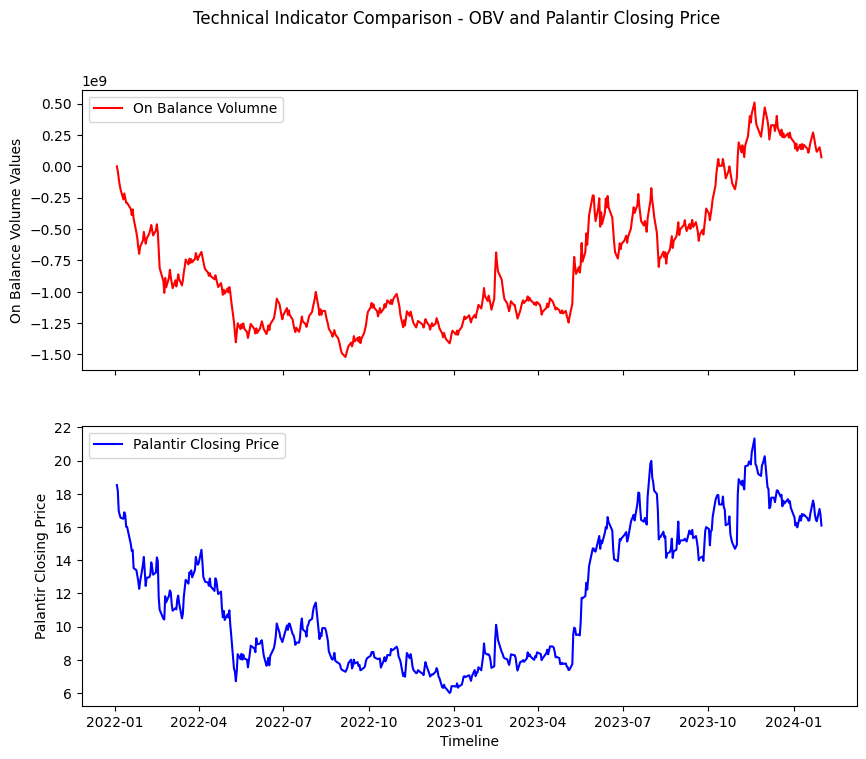

In [30]:
def obv(group):

    volume = pltr['Volume']
    change = pltr['Close'].diff()

    prev_obv = 0
    obv_values = []

    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        prev_obv = current_obv
        obv_values.append(current_obv)

    return pd.Series(obv_values, index=pltr.index, name='On Balance Volumne')


obv_values = obv(pltr)

pltr['OBV'] = obv_values


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(pltr['OBV'], label='On Balance Volumne',color='red')
ax1.set_ylabel('On Balance Volume Values')

ax1.legend(loc='upper left')

ax2.plot(pltr['Close'], label = 'Palantir Closing Price', color='blue')
ax2.set_ylabel('Palantir Closing Price', color='black')
ax2.tick_params('y', colors='black')


ax2.legend(loc='upper left')


fig.suptitle('Technical Indicator Comparison - OBV and Palantir Closing Price')
plt.xlabel('Timeline')


Pltr Price Rate of Change (PROC)

Text(0.5, 0, 'Timeline')

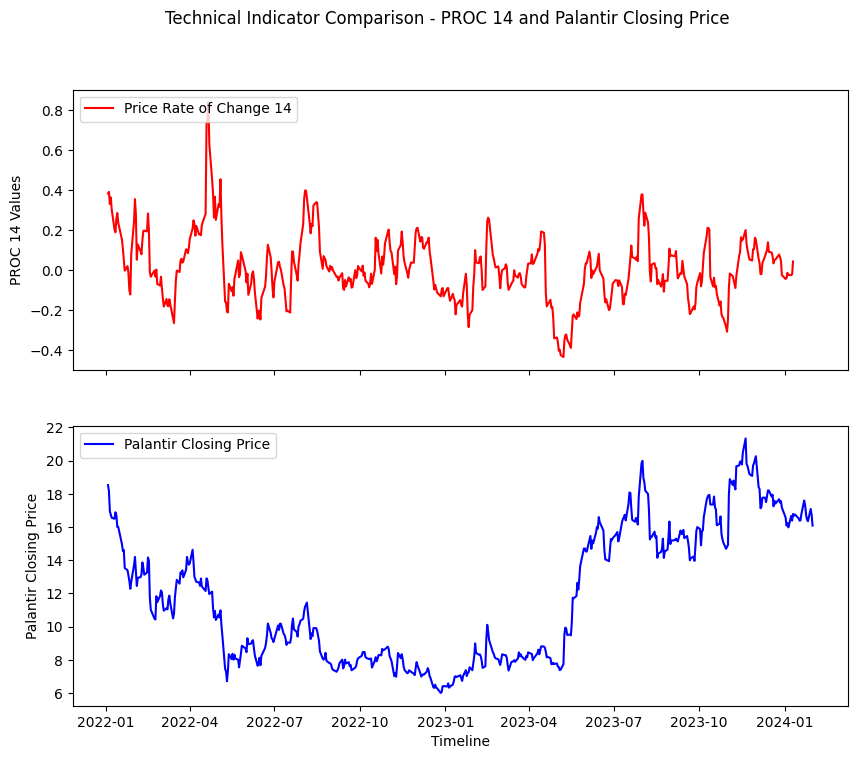

In [31]:
n = 1
pltr['PROC 1'] = (pltr['Close'] - pltr['Close'].shift(-n)) / pltr['Close'].shift(-n) # calculating PROC using the same formula given in my paper

n = 5
pltr['PROC 5'] = (pltr['Close'] - pltr['Close'].shift(-n)) / pltr['Close'].shift(-n)

n = 14
pltr['PROC 14'] = (pltr['Close'] - pltr['Close'].shift(-n)) / pltr['Close'].shift(-n)

n = 21
pltr['PROC 21'] = (pltr['Close'] - pltr['Close'].shift(-n)) / pltr['Close'].shift(-n)

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(pltr['PROC 14'], label = 'Price Rate of Change 14', color = 'red')
ax1.set_ylabel('PROC 14 Values')

ax1.legend(loc='upper left')

ax2.plot(pltr['Close'], label='Palantir Closing Price', color='blue')
ax2.set_ylabel('Palantir Closing Price')

ax2.legend(loc='upper left')


fig.suptitle('Technical Indicator Comparison - PROC 14 and Palantir Closing Price')
plt.xlabel('Timeline')

*Showcase* the power of MACD/RSI. Leads to a discovery on why my models performe the way they *do*

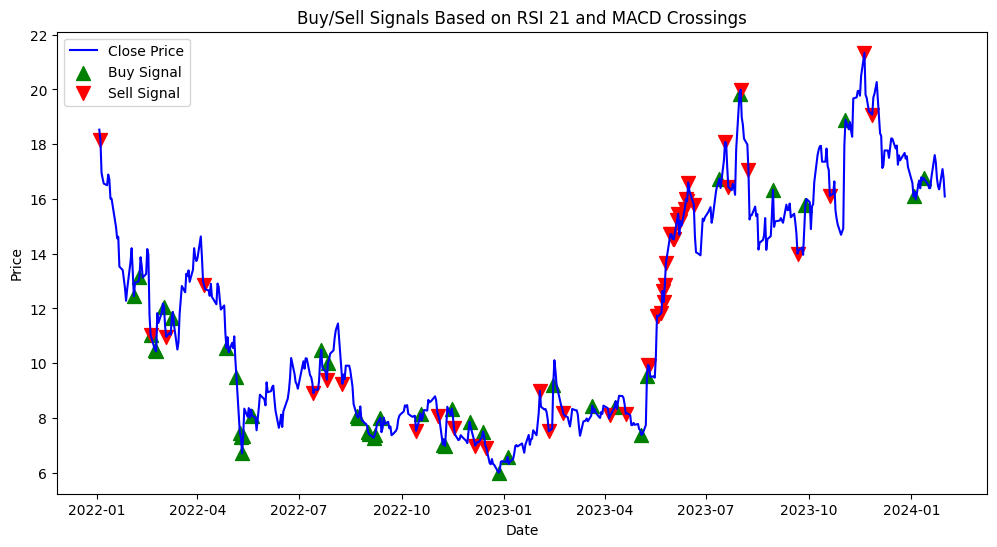

In [32]:
oversold_threshold = {'RSI 21': 30}
overbought_threshold = {'RSI 21': 75}

buy_signals = []
sell_signals = []


for i in range(len(pltr)):
    signal = ''

    for indicator, threshold in oversold_threshold.items():
        if pltr[indicator].iloc[i] < threshold:
            signal += 'Oversold '
    for indicator, threshold in overbought_threshold.items():
        if pltr[indicator].iloc[i] > threshold:
            signal += 'Overbought '

    if pltr['MACD'].iloc[i] > pltr['SignalLine'].iloc[i] and pltr['MACD'].iloc[i-1] <= pltr['SignalLine'].iloc[i-1]:
        signal += 'Bullish Cross '
    elif pltr['MACD'].iloc[i] < pltr['SignalLine'].iloc[i] and pltr['MACD'].iloc[i-1] >= pltr['SignalLine'].iloc[i-1]:
        signal += 'Bearish Cross '

    if 'Oversold' in signal or 'Bullish Cross' in signal:
        buy_signals.append((pltr.index[i], pltr['Close'].iloc[i]))
    if 'Overbought' in signal or 'Bearish Cross' in signal:
        sell_signals.append((pltr.index[i], pltr['Close'].iloc[i]))

plt.figure(figsize=(12, 6))
plt.plot(pltr.index, pltr['Close'], label='Close Price', color='blue')
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='^', s=100)
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='v', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy/Sell Signals Based on RSI 21 and MACD Crossings')
plt.legend()
plt.show()

Time Series Analysis for Palantir. The purpose of this time series is to identify how news can have a potential affect on my Palantir models performances

[*********************100%%**********************]  1 of 1 completed


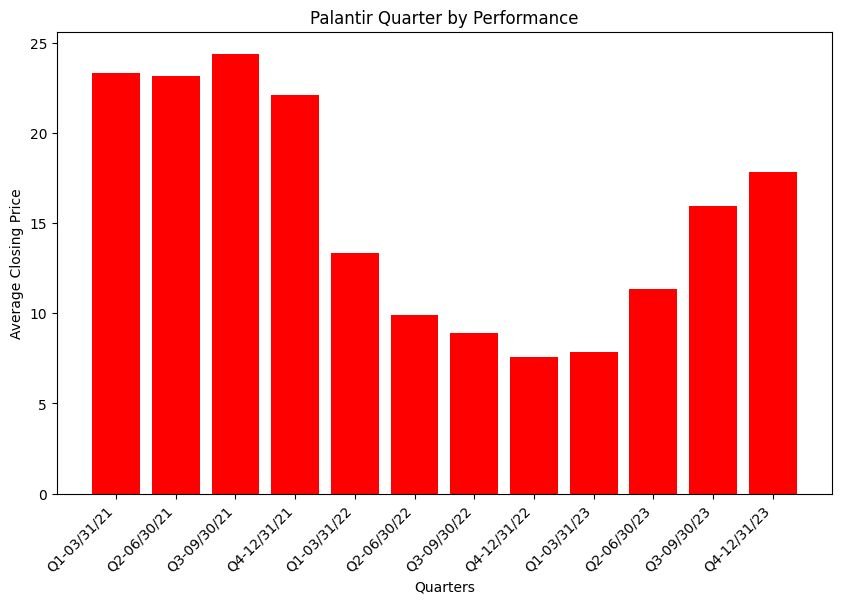

On average Palantir generally performs the best in Quarter: 3


In [33]:
new_pltr = yf.download('PLTR', start = '2021-03-31', end = '2024-01-01')

pltr_quart_performance = new_pltr.resample('Q').mean()

avg_closing_prices = new_pltr.groupby(new_pltr.index.quarter)['Close'].mean()

best_quarter = avg_closing_prices.idxmax()
best_quarter = (best_quarter)

pltr_quart_performance['Date'] = pltr_quart_performance.index.to_period('Q').strftime('Q%q-%D')

plt.figure(figsize=(10,6))
plt.bar(pltr_quart_performance['Date'], pltr_quart_performance['Close'],color='red')
plt.title('Palantir Quarter by Performance')
plt.xlabel('Quarters')
plt.ylabel('Average Closing Price')
plt.xticks(rotation = 45, ha='right')
plt.show()

print('On average Palantir generally performs the best in Quarter:', best_quarter)

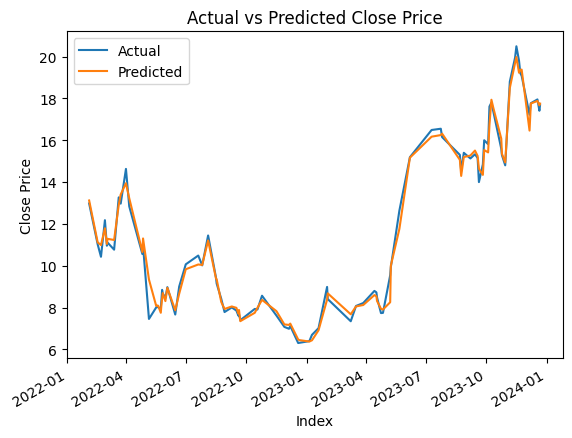

Training Mean Aboslute Error: 0.17385226608400722
Test Mean Aboslute Error: 0.2657651480696971
Mean Squared Error 0.1457690764323767
R2 Score 0.9909035980724943


In [34]:
pltr['Next_Close'] = pltr['Close'].shift(-1)

pltr = pltr.dropna()

predictors = ['SMA_1','SMA_5','PROC 1']

target_variable = 'Next_Close'

x = pltr[predictors]
y = pltr[target_variable]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=350, min_samples_split=3, max_depth=5)


model.fit(x_train, y_train)

preds = model.predict(x_test)

combined = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
combined.plot()
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

mae_train = mean_absolute_error(y_train, model.predict(x_train))
mae_test = mean_absolute_error(y_test, preds)
mse = mean_squared_error(preds, y_test)
r2 = r2_score(preds, y_test)

print("Training Mean Aboslute Error:", mae_train)
print("Test Mean Aboslute Error:", mae_test)
print('Mean Squared Error', mse)
print('R2 Score', r2)

<ipython-input-35-70a6773e8ac4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = train_data['Close'].shift(-1)
<ipython-input-35-70a6773e8ac4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Target'] = test_data['Close'].shift(-1)


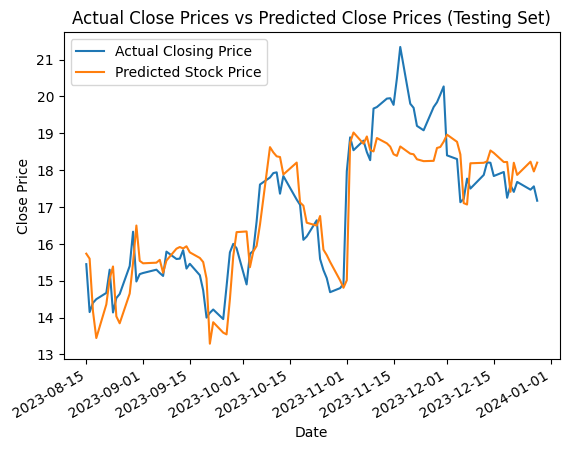

Training Mean Absolute Error: 0.25868013933707695
Test Mean Absolute Error: 0.7164607810423348
Mean Squared Error: 0.8180689143643616
R2 Score: 0.7677515082953793


In [35]:
total_samples = len(pltr)
train_samples = int(total_samples * 0.8)

split_date = pltr.index[train_samples]

train_data = pltr[pltr.index <= split_date]
test_data = pltr[pltr.index > split_date]

train_data['Target'] = train_data['Close'].shift(-1)
test_data['Target'] = test_data['Close'].shift(-1)

train_data = train_data.dropna()
test_data = test_data.dropna()

predictors = ['RSI 5', 'EMA_9', 'MACD', 'SMA_5', '%K 5', 'W%R 5','OBV','Open','High','Low','Close','Volume']

x_train = train_data[predictors]
y_train = train_data['Target']
x_test = test_data[predictors]
y_test = test_data['Target']

model = RandomForestRegressor(n_estimators=500, min_samples_split=5, max_depth=5)

model.fit(x_train, y_train)

preds = model.predict(x_test)

combined_results = pd.DataFrame({'Actual Closing Price': y_test, 'Predicted Stock Price': preds}, index=y_test.index)

combined_results.plot()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual Close Prices vs Predicted Close Prices (Testing Set)')
plt.legend()
plt.show()

mae_train = mean_absolute_error(y_train, model.predict(x_train))
mae_test = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Training Mean Absolute Error:", mae_train)
print("Test Mean Absolute Error:", mae_test)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

This is where the time series analysis comes into play. In November 2023 Palantir had an unexpected earnings beat which surged Palantir's stock price by 35.5%. Thus leading to a potential descrepency in predictions because my model was not prepared for a random 35.5% surge in price

In [36]:
total_samples = len(pltr)
train_samples = int(total_samples * 0.8)

split_index = train_samples

train_data = pltr[:split_index]
test_data = pltr[split_index:]

train_data['Next_Close'] = train_data['Close'].shift(-1)
train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)

test_data['Next_Close'] = test_data['Close'].shift(-1)
test_data['Target'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

train_data = train_data.dropna()
test_data = test_data.dropna()

predictors = ['RSI 14', 'PROC 5', 'MACD', 'OBV', 'EMA_9','%K 14','SMA_5','SignalLine','W%R 14']

x_train = train_data[predictors]
y_train = train_data['Target']
x_test = test_data[predictors]
y_test = test_data['Target']

model = RandomForestClassifier(n_estimators=300, max_depth=1, min_samples_leaf=1, min_samples_split=3)

model.fit(x_train, y_train)

preds = model.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

report = classification_report(y_test, preds)
print("Classification Report: ")
print(report)

<ipython-input-36-686919ce1cb2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Next_Close'] = train_data['Close'].shift(-1)
<ipython-input-36-686919ce1cb2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)
<ipython-input-36-686919ce1cb2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Accuracy: 0.5
Precision: 0.7692307692307693
Recall: 0.18518518518518517
F1-score: 0.29850746268656714
Classification Report: 
              precision    recall  f1-score   support

           0       0.46      0.93      0.61        40
           1       0.77      0.19      0.30        54

    accuracy                           0.50        94
   macro avg       0.61      0.56      0.46        94
weighted avg       0.64      0.50      0.43        94



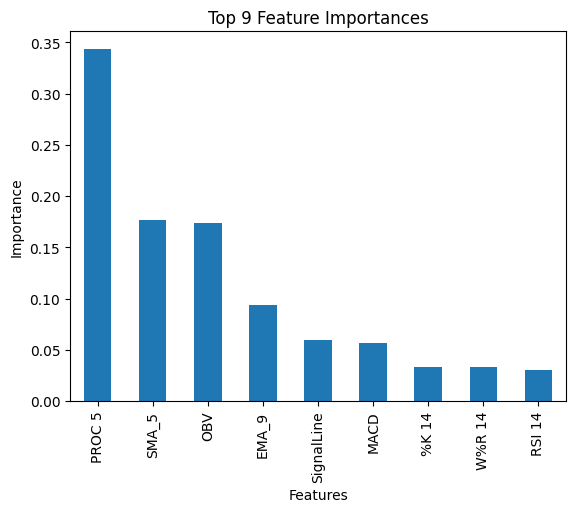

In [37]:
f_list = list(x_train.columns)
f_importance = pd.Series(model.feature_importances_, index=f_list).sort_values(ascending=False)

importances = f_importance.nlargest(15).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 9 Feature Importances')
plt.show()

In [38]:
total_samples = len(pltr)
train_samples = int(total_samples * 0.8)

split_index = train_samples

train_data = pltr[:split_index]
test_data = pltr[split_index:]

train_data['Next_Close'] = train_data['Close'].shift(-1)
train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)

test_data['Next_Close'] = test_data['Close'].shift(-1)
test_data['Target'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

train_data = train_data.dropna()
test_data = test_data.dropna()

predictors = ['RSI 14', 'PROC 5', 'MACD', 'OBV', 'EMA_9', '%K 14', 'SMA_5', 'SignalLine', 'W%R 14']

x_train = train_data[predictors]
y_train = train_data['Target']
x_test = test_data[predictors]
y_test = test_data['Target']

model = xgb.XGBClassifier(n_estimators=300, max_depth=1, learning_rate=0.1, min_child_weight=1)

model.fit(x_train, y_train)

preds = model.predict(x_test)


accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

report = classification_report(y_test, preds)
print("Classification Report: ")
print(report)



Accuracy: 0.4574468085106383
Precision: 0.6
Recall: 0.16666666666666666
F1-score: 0.2608695652173913
Classification Report: 
              precision    recall  f1-score   support

           0       0.43      0.85      0.57        40
           1       0.60      0.17      0.26        54

    accuracy                           0.46        94
   macro avg       0.52      0.51      0.42        94
weighted avg       0.53      0.46      0.39        94



<ipython-input-38-a3354972fa18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Next_Close'] = train_data['Close'].shift(-1)
<ipython-input-38-a3354972fa18>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)
<ipython-input-38-a3354972fa18>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

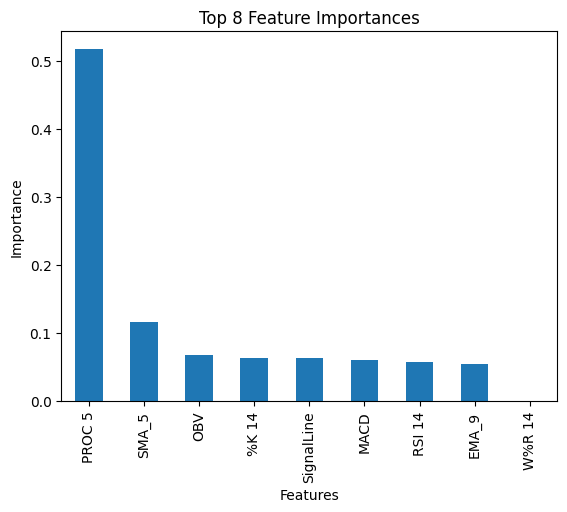

In [39]:
f_list = list(x_train.columns)
f_importance = pd.Series(model.feature_importances_, index=f_list).sort_values(ascending=False)

importances = f_importance.nlargest(15).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 8 Feature Importances')
plt.show()

**Extracting nasdaq's stock market data using YF API**




In [40]:
nasdaq = yf.download('^IXIC',
                      start='2022-01-01',
                      end='2024-01-01'
)

[*********************100%%**********************]  1 of 1 completed


Simple Moving Averages

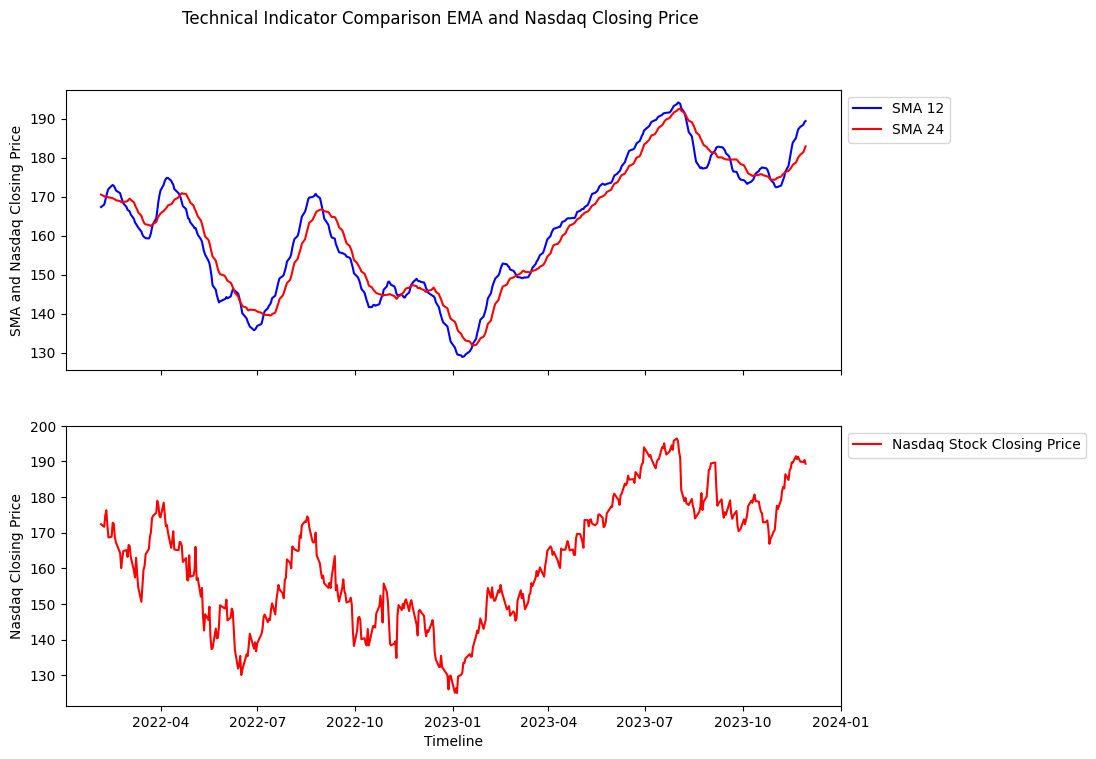

In [41]:
nasdaq['SMA_1'] = nasdaq['Close'].rolling(window=1).mean()
nasdaq['SMA_5'] = nasdaq['Close'].rolling(window=5).mean()
nasdaq['SMA_12'] = nasdaq['Close'].rolling(window=12).mean()
nasdaq['SMA_24'] = nasdaq['Close'].rolling(window=24).mean()

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(data['SMA_12'], label = 'SMA 12',color='blue')
ax1.plot(data['SMA_24'], label = 'SMA 24', color='red')
ax1.set_ylabel('SMA and Nasdaq Closing Price', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))

ax2.plot(data['Close'], label = 'Nasdaq Stock Closing Price', color = 'Red')
ax2.set_ylabel('Nasdaq Closing Price')

ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison EMA and Nasdaq Closing Price')
plt.xlabel('Timeline')
plt.show()

Nasdaq EMA

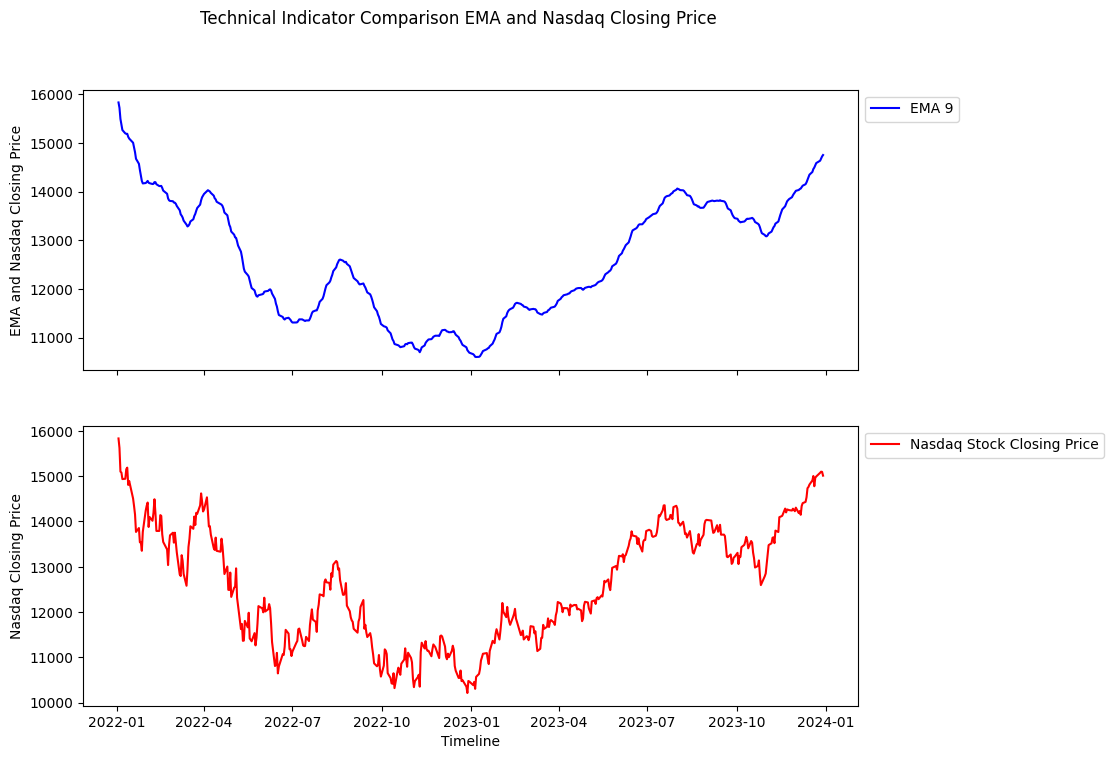

In [42]:
nasdaq['EMA_9'] = nasdaq['Close'].ewm(9).mean()

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(nasdaq['EMA_9'], label = 'EMA 9',color='blue')
ax1.set_ylabel('EMA and Nasdaq Closing Price', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))

ax2.plot(nasdaq['Close'], label = 'Nasdaq Stock Closing Price', color = 'Red')
ax2.set_ylabel('Nasdaq Closing Price')

ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison EMA and Nasdaq Closing Price')
plt.xlabel('Timeline')
plt.show()

Nasdaq RSI

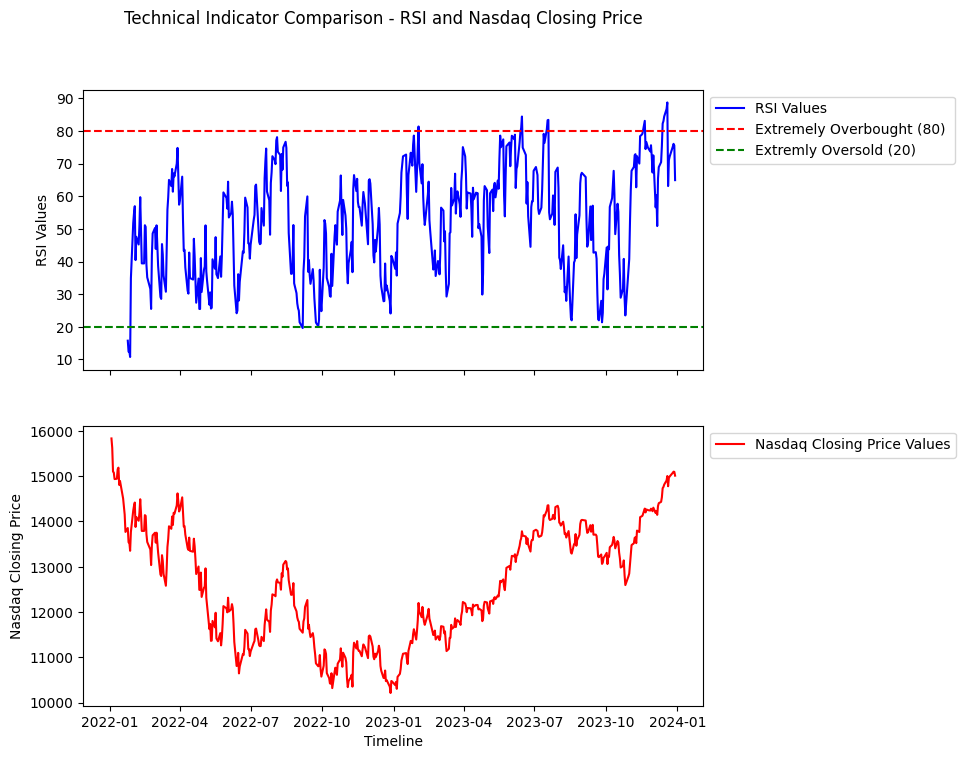

In [43]:
n = 1

nasdaq['Change_in_price'] = nasdaq['Close'].diff()

up_day = nasdaq['Change_in_price'].copy()
down_day = nasdaq['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

nasdaq['RSI 1'] = rsi

n = 5

nasdaq['Change_in_price'] = nasdaq['Close'].diff()

up_day = nasdaq['Change_in_price'].copy()
down_day = nasdaq['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

nasdaq['RSI 5'] = rsi


n = 14

nasdaq['Change_in_price'] = nasdaq['Close'].diff()

up_day = nasdaq['Change_in_price'].copy()
down_day = nasdaq['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

nasdaq['RSI 14'] = rsi



n = 21

nasdaq['Change_in_price'] = nasdaq['Close'].diff()

up_day = nasdaq['Change_in_price'].copy()
down_day = nasdaq['Change_in_price'].copy()

up_day[up_day < 0] = 0

down_day[down_day > 0] = 0

down_day = down_day.abs()

up_emwa = up_day.ewm(span=n, min_periods=n).mean()

down_emwa = down_day.ewm(span=n, min_periods=n).mean()

relative_strength = up_emwa / down_emwa

rsi = 100.0 - (100.0 / (1.0 + relative_strength))

nasdaq['RSI 21'] = rsi


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (8,8), sharex=True)

ax1.plot(nasdaq['RSI 14'], label='RSI Values', color='blue')
ax1.set_ylabel('RSI Values')

ax1.axhline(y=80, color = 'red', linestyle='--',label = 'Extremely Overbought (80) ')
ax1.axhline(y=20, color='green', linestyle='--', label = 'Extremly Oversold (20) ')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))

ax2.plot(nasdaq['Close'],label='Nasdaq Closing Price Values', color='red')
ax2.set_ylabel('Nasdaq Closing Price')

ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison - RSI and Nasdaq Closing Price')

plt.xlabel('Timeline')

plt.show()

Nasdaq SO

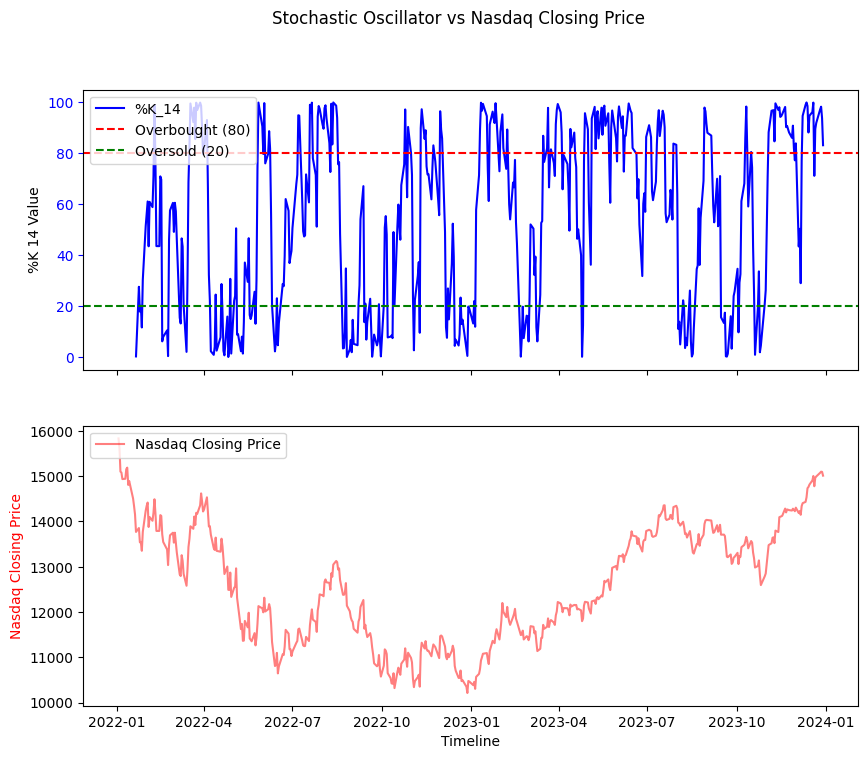

In [44]:
L14 = nasdaq['Low'].rolling(window=1).min()
H14 = nasdaq['High'].rolling(window=1).max()


L14 = nasdaq['Low'].rolling(window=5).min()
H14 = nasdaq['High'].rolling(window=5).max()
nasdaq['%K 5'] = 100 * ((nasdaq['Close']- L14) / (H14-L14))

L14 = nasdaq['Low'].rolling(window=14).min()
H14 = nasdaq['High'].rolling(window=14).max()
nasdaq['%K 14'] = 100 * ((nasdaq['Close']- L14) / (H14-L14))



L14 = nasdaq['Low'].rolling(window=21).min()
H14 = nasdaq['High'].rolling(window=21).max()
nasdaq['%K 21'] = 100 * ((nasdaq['Close']- L14) / (H14-L14))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(nasdaq['%K 14'], label='%K_14', color='blue')
ax1.set_ylabel('%K 14 Value', color='black')
ax1.tick_params('y', colors='blue')


ax1.axhline(y=80, color='r', linestyle='--', label='Overbought (80)')
ax1.axhline(y=20, color='g', linestyle='--', label='Oversold (20)')

ax1.legend(loc='upper left')

ax2.plot(nasdaq['Close'], label='Nasdaq Closing Price', alpha=0.5, color='red')
ax2.set_ylabel('Nasdaq Closing Price', color='red')
ax2.tick_params('y', colors='black')

ax2.legend(loc='upper left')

fig.suptitle('Stochastic Oscillator vs Nasdaq Closing Price')
plt.xlabel('Timeline')

plt.show()


Nasdaq W%R

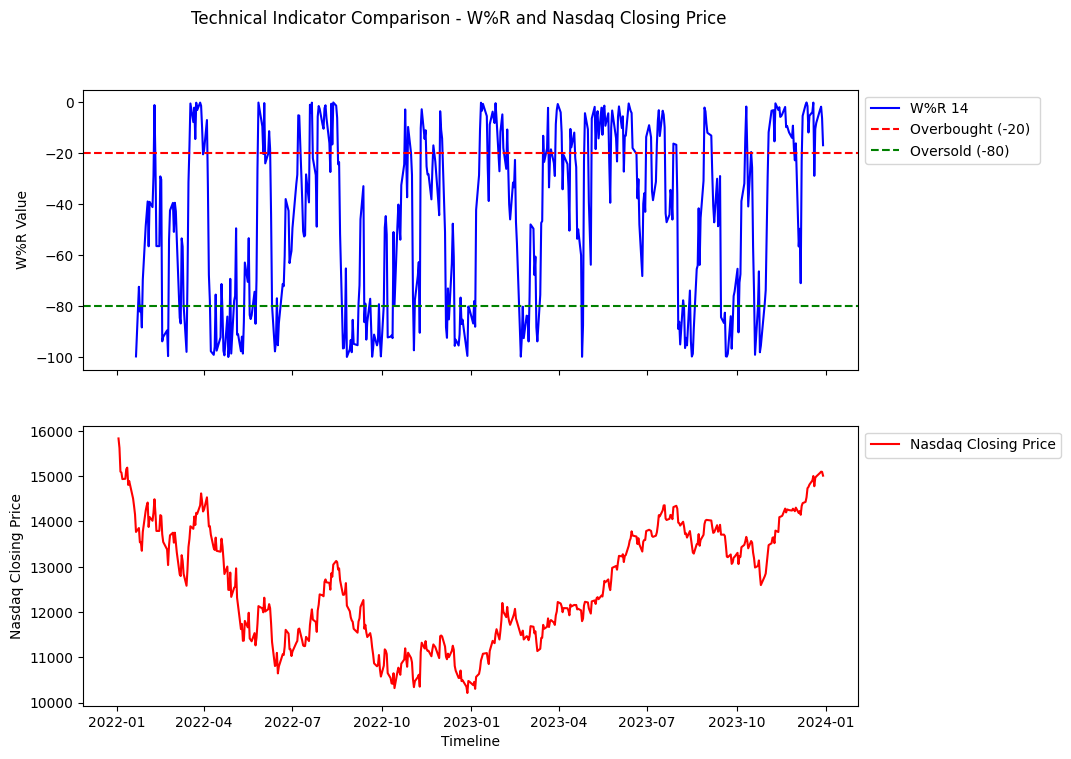

In [45]:
H14 = nasdaq['High'].rolling(window=1).max()
L14 = nasdaq['Low'].rolling(window=1).min()
nasdaq['W%R 1'] = (H14 - nasdaq['Close']) / (H14 - L14) * -100


H14 = nasdaq['High'].rolling(window=5).max()
L14 = nasdaq['Low'].rolling(window=5).min()
nasdaq['W%R 5'] = (H14 - nasdaq['Close']) / (H14 - L14) * -100


H14 = nasdaq['High'].rolling(window=14).max()
L14 = nasdaq['Low'].rolling(window=14).min()
nasdaq['W%R 14'] = (H14 - nasdaq['Close']) / (H14 - L14) * -100

H14 = nasdaq['High'].rolling(window=21).max()
L14 = nasdaq['Low'].rolling(window=21).min()
nasdaq['W%R 21'] = (H14 - nasdaq['Close']) / (H14 - L14) * -100

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(nasdaq['W%R 14'], label = 'W%R 14', color='blue') # Change the line plotting itself
ax1.set_ylabel('W%R Value')


ax1.axhline(y=-20,color='r', linestyle='--', label = 'Overbought (-20) ')
ax1.axhline(y=-80,color='g', linestyle='--', label='Oversold (-80) ')

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax2.plot(nasdaq['Close'], label = 'Nasdaq Closing Price', color='red')
ax2.set_ylabel('Nasdaq Closing Price')


ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.suptitle('Technical Indicator Comparison - W%R and Nasdaq Closing Price')
plt.xlabel('Timeline')
plt.show()

Nasdaq MACD

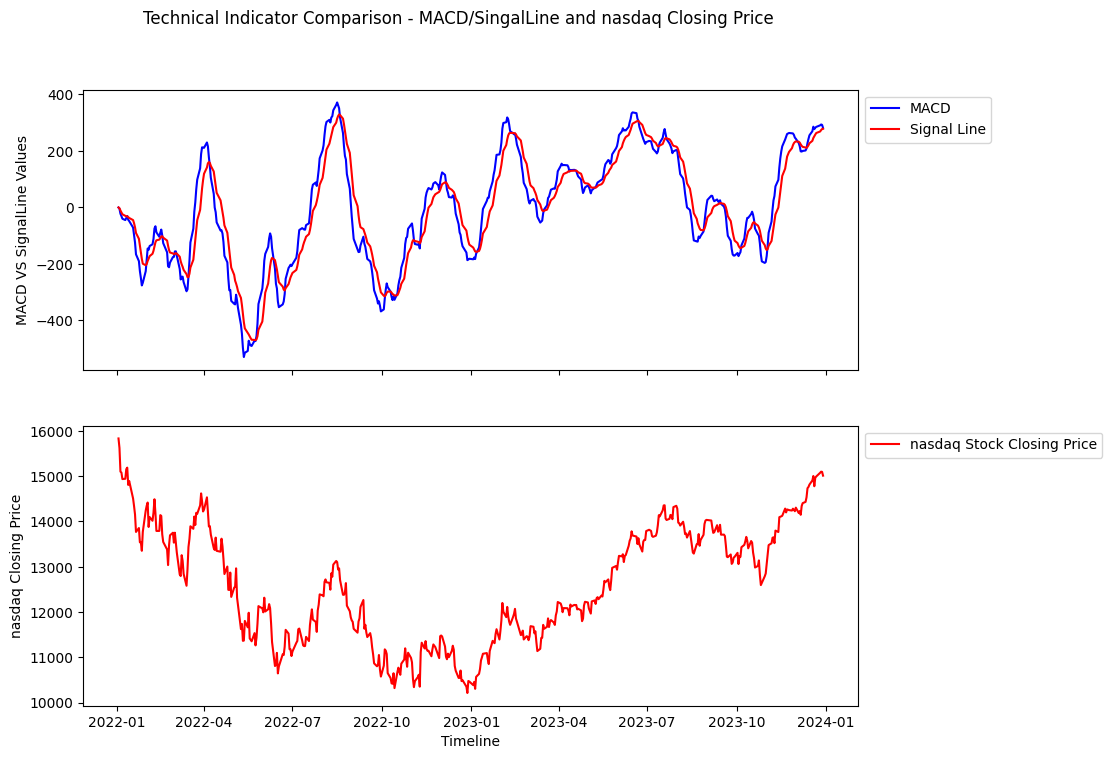

In [46]:
ema_26 = nasdaq['Close'].ewm(span=26).mean()
ema_12 = nasdaq['Close'].ewm(span=12).mean()

nasdaq['MACD'] = ema_12 - ema_26
nasdaq['SignalLine'] = nasdaq['MACD'].ewm(span = 9).mean()

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(nasdaq['MACD'], label = 'MACD',color='blue')
ax1.plot(nasdaq['SignalLine'], label = 'Signal Line', color='red')
ax1.set_ylabel('MACD VS SignalLine Values', color = 'Black')

ax1.legend(loc='upper left',bbox_to_anchor=(1, 1))


ax2.plot(nasdaq['Close'], label = 'nasdaq Stock Closing Price', color = 'Red')
ax2.set_ylabel('nasdaq Closing Price')


ax2.legend(loc='upper left',bbox_to_anchor=(1, 1))


fig.suptitle('Technical Indicator Comparison - MACD/SingalLine and nasdaq Closing Price')
plt.xlabel('Timeline')

plt.show()


# essentially if MACD is > the Signalline column than this indicates a buy signal, vice versa this indicates a sell signal
# if the MACD (Blue line) is above the SignalLine (red line) than that is indicating a bullish signal
# if the MACD is below the signalline than that is indicating a bearish signal

Nasdaq OBV

Text(0.5, 0, 'Timeline')

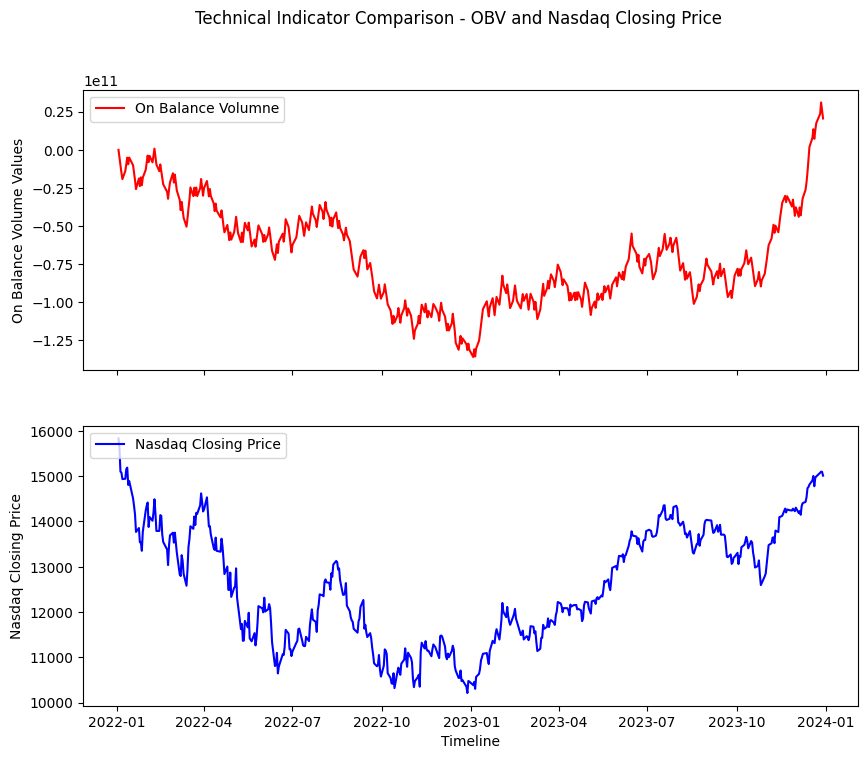

In [47]:
def obv(group):

    volume = nasdaq['Volume']
    change = nasdaq['Close'].diff()

    prev_obv = 0
    obv_values = []

    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        prev_obv = current_obv
        obv_values.append(current_obv)

    return pd.Series(obv_values, index=nasdaq.index, name='On Balance Volumne')


obv_values = obv(nasdaq)

nasdaq['OBV'] = obv_values

nasdaq.head(30)

fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(nasdaq['OBV'], label='On Balance Volumne',color='red')
ax1.set_ylabel('On Balance Volume Values')

ax1.legend(loc='upper left')

ax2.plot(nasdaq['Close'], label = 'Nasdaq Closing Price', color='blue')
ax2.set_ylabel('Nasdaq Closing Price', color='black')
ax2.tick_params('y', colors='black')


ax2.legend(loc='upper left')


fig.suptitle('Technical Indicator Comparison - OBV and Nasdaq Closing Price')
plt.xlabel('Timeline')

Nasdaq PROC

[]

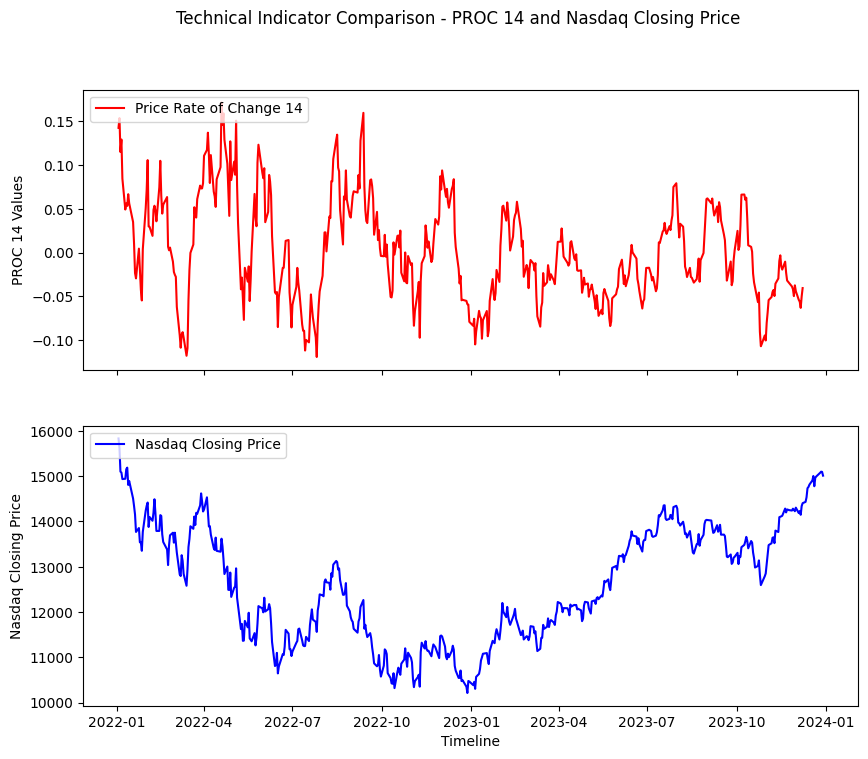

In [48]:
n = 1

nasdaq['PROC 1'] = (nasdaq['Close'] - nasdaq['Close'].shift(-n)) / nasdaq['Close'].shift(-n)

n = 6

nasdaq['PROC 5'] = (nasdaq['Close'] - nasdaq['Close'].shift(-n)) / nasdaq['Close'].shift(-n)

n = 14

nasdaq['PROC 14'] = (nasdaq['Close'] - nasdaq['Close'].shift(-n)) / nasdaq['Close'].shift(-n)

n = 21

nasdaq['PROC 21'] = (nasdaq['Close'] - nasdaq['Close'].shift(-n)) / nasdaq['Close'].shift(-n)


fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8), sharex=True)

ax1.plot(nasdaq['PROC 14'], label = 'Price Rate of Change 14', color = 'red')
ax1.set_ylabel('PROC 14 Values')

ax1.legend(loc='upper left')

ax2.plot(nasdaq['Close'], label='Nasdaq Closing Price', color='blue')
ax2.set_ylabel('Nasdaq Closing Price')

ax2.legend(loc='upper left')


fig.suptitle('Technical Indicator Comparison - PROC 14 and Nasdaq Closing Price')
plt.xlabel('Timeline')
plt.plot()

Nasdaq MACD and RSI

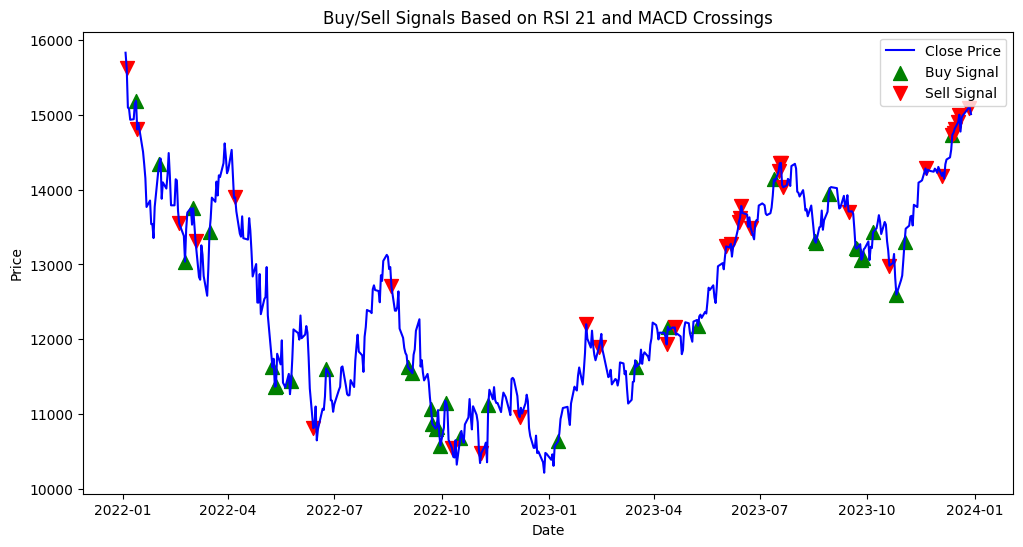

In [49]:
oversold_threshold = {'RSI 21': 30}
overbought_threshold = {'RSI 21': 75}

buy_signals = []
sell_signals = []


for i in range(len(nasdaq)):
    signal = ''

    for indicator, threshold in oversold_threshold.items():
        if nasdaq[indicator].iloc[i] < threshold:
            signal += 'Oversold '
    for indicator, threshold in overbought_threshold.items():
        if nasdaq[indicator].iloc[i] > threshold:
            signal += 'Overbought '

    if nasdaq['MACD'].iloc[i] > nasdaq['SignalLine'].iloc[i] and nasdaq['MACD'].iloc[i-1] <= nasdaq['SignalLine'].iloc[i-1]:
        signal += 'Bullish Cross '
    elif nasdaq['MACD'].iloc[i] < nasdaq['SignalLine'].iloc[i] and nasdaq['MACD'].iloc[i-1] >= nasdaq['SignalLine'].iloc[i-1]:
        signal += 'Bearish Cross '

    if 'Oversold' in signal or 'Bullish Cross' in signal:
        buy_signals.append((nasdaq.index[i], nasdaq['Close'].iloc[i]))
    if 'Overbought' in signal or 'Bearish Cross' in signal:
        sell_signals.append((nasdaq.index[i], nasdaq['Close'].iloc[i]))

plt.figure(figsize=(12, 6))
plt.plot(nasdaq.index, nasdaq['Close'], label='Close Price', color='blue')
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='^', s=100)
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='v', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy/Sell Signals Based on RSI 21 and MACD Crossings')
plt.legend()
plt.show()

Nasdaq Time Series

[*********************100%%**********************]  1 of 1 completed


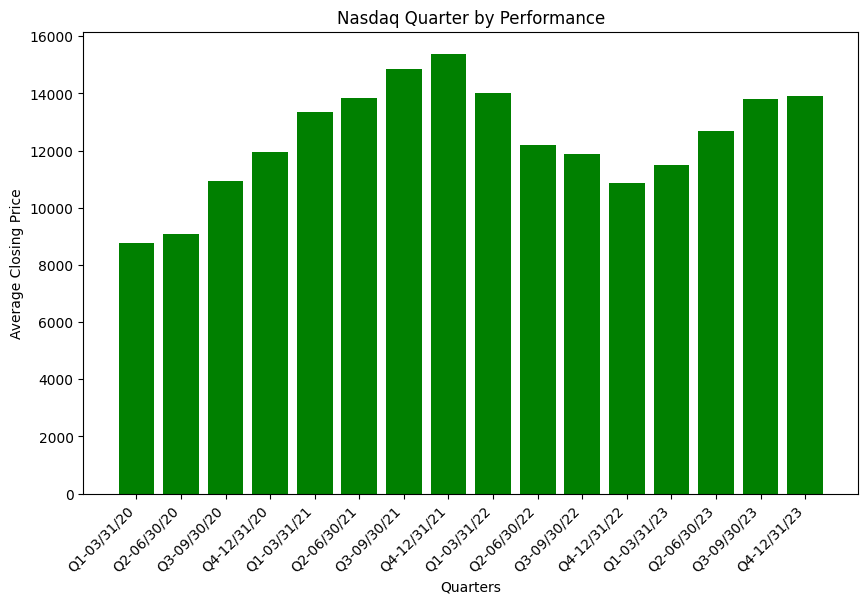

On average Nasdaq generally performs the best in Quarter: 4


In [50]:
new_nasdaq = yf.download('^IXIC', start = '2020-01-01', end = '2024-01-01')

nasdaq_quart_performance = new_nasdaq.resample('Q').mean()

avg_closing_prices = new_nasdaq.groupby(new_nasdaq.index.quarter)['Close'].mean()

best_quarter = avg_closing_prices.idxmax()
best_quarter = (best_quarter)

nasdaq_quart_performance['Date'] = nasdaq_quart_performance.index.to_period('Q').strftime('Q%q-%D')

plt.figure(figsize=(10,6))
plt.bar(nasdaq_quart_performance['Date'], nasdaq_quart_performance['Close'],color='green')
plt.title('Nasdaq Quarter by Performance')
plt.xlabel('Quarters')
plt.ylabel('Average Closing Price')
plt.xticks(rotation = 45, ha='right')
plt.show()

print('On average Nasdaq generally performs the best in Quarter:', best_quarter)

Failed First Nasdaq Model

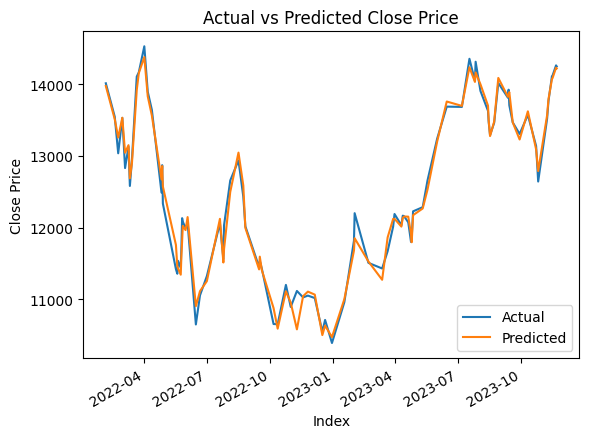

Training Mean Aboslute Error: 55.86261608431408
Test Mean Aboslute Error: 93.75508950337938
Mean Squared Error 17206.802185920278
R2 Score 0.9865753724283538


In [51]:
nasdaq['Next_Close'] = nasdaq['Close'].shift(-1)

nasdaq = nasdaq.dropna()

predictors = ['SMA_1','SMA_5','PROC 1']

target_variable = 'Next_Close'

x = nasdaq[predictors]
y = nasdaq[target_variable]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=350, min_samples_split=3, max_depth=5)

model.fit(x_train, y_train)

preds = model.predict(x_test)

combined = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
combined.plot()
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

mae_train = mean_absolute_error(y_train, model.predict(x_train))
mae_test = mean_absolute_error(y_test, preds)
mse = mean_squared_error(preds, y_test)
r2 = r2_score(preds, y_test)

print("Training Mean Aboslute Error:", mae_train)
print("Test Mean Aboslute Error:", mae_test)
print('Mean Squared Error', mse)
print('R2 Score', r2)

Nasdaq ML All Optimized Indicators

<ipython-input-52-28107992b7b5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = train_data['Close'].shift(-1)
<ipython-input-52-28107992b7b5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Target'] = test_data['Close'].shift(-1)


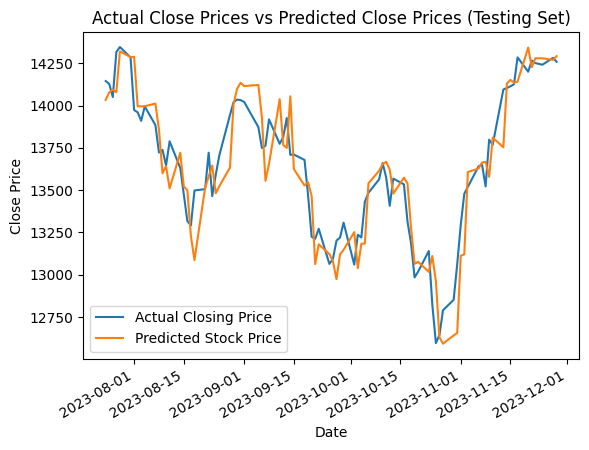

Training Mean Absolute Error: 117.67187318841039
Test Mean Absolute Error: 131.9239311548654
Mean Squared Error: 28393.205343699352
R2 Score: 0.8391273193842205


In [52]:
total_samples = len(nasdaq)
train_samples = int(total_samples * 0.8)

split_date = nasdaq.index[train_samples]

train_data = nasdaq[nasdaq.index <= split_date]
test_data = nasdaq[nasdaq.index > split_date]

train_data['Target'] = train_data['Close'].shift(-1)
test_data['Target'] = test_data['Close'].shift(-1)

train_data = train_data.dropna()
test_data = test_data.dropna()

predictors = ['RSI 5', 'EMA_9', 'MACD', 'SMA_5', '%K 5', 'W%R 5','OBV','Open','High','Low','Close','Volume']

x_train = train_data[predictors]
y_train = train_data['Target']
x_test = test_data[predictors]
y_test = test_data['Target']

model = RandomForestRegressor(n_estimators=500, min_samples_split=5, max_depth=5)

model.fit(x_train, y_train)

preds = model.predict(x_test)

results = pd.DataFrame({'Actual Closing Price': y_test, 'Predicted Stock Price': preds}, index=y_test.index)

results.plot()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual Close Prices vs Predicted Close Prices (Testing Set)')
plt.legend()
plt.show()

mae_train = mean_absolute_error(y_train, model.predict(x_train))
mae_test = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Training Mean Absolute Error:", mae_train)
print("Test Mean Absolute Error:", mae_test)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

In [53]:
total_samples = len(nasdaq)
train_samples = int(total_samples * 0.8)
split_index = train_samples

train_data = nasdaq[:split_index]
test_data = nasdaq[split_index:]

train_data['Next_Close'] = train_data['Close'].shift(-1)
train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)

test_data['Next_Close'] = test_data['Close'].shift(-1)
test_data['Target'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

train_data = train_data.dropna()
test_data = test_data.dropna()

predictors = ['RSI 14', 'PROC 5', 'MACD', 'OBV', 'EMA_9', '%K 14', 'SMA_5', 'SignalLine', 'W%R 14']

x_train = train_data[predictors]
y_train = train_data['Target']

x_test = test_data[predictors]
y_test = test_data['Target']

model = RandomForestClassifier(n_estimators=300, max_depth=1, min_samples_leaf=1, min_samples_split=3)

model.fit(x_train, y_train)

preds = model.predict(x_test)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

f1 = f1_score(y_test, preds)
report = classification_report(y_test, preds)
print("Classification Report: ")
print(report)

<ipython-input-53-9fd47a7f3eef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Next_Close'] = train_data['Close'].shift(-1)
<ipython-input-53-9fd47a7f3eef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)
<ipython-input-53-9fd47a7f3eef>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Accuracy: 0.6043956043956044
Precision: 0.8888888888888888
Recall: 0.32
F1-score: 0.2608695652173913
Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.95      0.68        41
           1       0.89      0.32      0.47        50

    accuracy                           0.60        91
   macro avg       0.71      0.64      0.58        91
weighted avg       0.73      0.60      0.57        91



In [54]:
total_samples = len(nasdaq)
train_samples = int(total_samples * 0.8)

split_index = train_samples

train_data = nasdaq[:split_index]
test_data = nasdaq[split_index:]

train_data['Next_Close'] = train_data['Close'].shift(-1)
train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)

test_data['Next_Close'] = test_data['Close'].shift(-1)
test_data['Target'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

train_data = train_data.dropna()
test_data = test_data.dropna()

# Define predictors
predictors = ['RSI 14', 'PROC 5', 'MACD', 'OBV', 'EMA_9', '%K 14', 'SMA_5', 'SignalLine', 'W%R 14']

x_train = train_data[predictors]
y_train = train_data['Target']

x_test = test_data[predictors]
y_test = test_data['Target']

model = xgb.XGBClassifier(n_estimators=300, max_depth=1, learning_rate=0.1, min_child_weight=1)

model.fit(x_train, y_train)

preds = model.predict(x_test)

accuracy = accuracy_score(y_test, preds)

precision = precision_score(y_test, preds)

recall = recall_score(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


f1 = f1_score(y_test, preds)

report = classification_report(y_test, preds)
print("Classification Report: ")
print(report)



Accuracy: 0.6263736263736264
Precision: 0.6333333333333333
Recall: 0.76
F1-score: 0.47058823529411764
Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.46      0.53        41
           1       0.63      0.76      0.69        50

    accuracy                           0.63        91
   macro avg       0.62      0.61      0.61        91
weighted avg       0.62      0.63      0.62        91



<ipython-input-54-07a3865f6174>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Next_Close'] = train_data['Close'].shift(-1)
<ipython-input-54-07a3865f6174>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Target'] = (train_data['Next_Close'] > train_data['Close']).astype(int)
<ipython-input-54-07a3865f6174>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

GridSearch was used on Apple, Palantir and Nasdaq
I put this at the bottom for the user to run the code smoothly

In [55]:
# Defining optiized hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1, 3, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy') # Performed grid search the different models
grid_search.fit(x_train, y_train)


best_params = grid_search.best_params_ # Retrieves and print best hyperparameters I did this for every model
print("Best Parameters:", best_params)


best_model = grid_search.best_estimator_ # Use the best model for predictions
best_preds = best_model.predict(x_test)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python

Best Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 300}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:37:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
